# Imports

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, impute
from IPython.display import display

plt.style.use('ggplot')

In [3]:
random_state = 42

# Data Collection

In [4]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col=0)
X_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col=0)

In [5]:
column_y = df_train.columns.difference(X_test.columns)[0]
X = df_train.drop(columns=column_y)
y = df_train[column_y]

In [6]:
X.index.intersection(X_test.index)

Int64Index([], dtype='int64', name='Id')

In [7]:
df_combined = pd.concat([X.assign(set='train'),
                         X_test.assign(set='test')], axis=0)

In [8]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

# Short EDA before Processing

## Comparison Train / Test

In [9]:
pd.concat([X.isna().sum().rename('train'),
           X_test.isna().sum().rename('test')], axis=1)\
    .astype('int')\
    .sort_values(['train', 'test'], ascending=False)\
    .style.background_gradient(vmin=0, vmax=max([X.shape[0], X_test.shape[0]]))

In [10]:
with pd.option_context('display.max_columns', None):
    display(df_train.sample(10))

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
745          120       RL         41.0     5395   Pave   NaN      IR1   
799           60       RL        104.0    13518   Pave   NaN      Reg   
812          120       RM          NaN     4438   Pave   NaN      Reg   
647           20       RL         60.0     7200   Pave   NaN      Reg   
1046          20       RL          NaN    13680   Pave   NaN      IR1   
1200          20       RL         75.0    11235   Pave   NaN      Reg   
868           20       RL         85.0     6970   Pave   NaN      Reg   
306           20       RL         80.0    10386   Pave   NaN      Reg   
40            90       RL         65.0     6040   Pave   NaN      Reg   
49           190       RM         33.0     4456   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
745          HLS    AllPub    Inside       Gtl      StoneBr       Norm   
799          Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
812          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
647          Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1046         Lvl    AllPub   CulDSac       Gtl      Edwards       Norm   
1200         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
868          Lvl    AllPub    Corner       Gtl       Sawyer      Feedr   
306          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
40           Lvl    AllPub    Inside       Gtl      Edwards       Norm   
49           Lvl    AllPub    Inside       Gtl      OldTown       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
745        Norm   TwnhsE     1Story            8            5       1993   
799        Norm     1Fam     2Story            9            5       2008   
812        Norm   TwnhsE     1Story            6            5       2004   
647        Norm     1Fam     1Story            5            5       1950   
1046       Norm     1Fam     1Story            3            5       1955   
1200       Norm     1Fam     1Story            4            5       1963   
868        Norm     1Fam     1Story            4            5       1961   
306        Norm     1Fam     1Story            8            5       2004   
40         Norm   Duplex     1Story            4            5       1955   
49         Norm   2fmCon     2Story            4            5       1920   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
745           1993     Gable  CompShg     HdBoard     HdBoard       None   
799           2009       Hip  CompShg     VinylSd     VinylSd      Stone   
812           2004     Gable  CompShg     VinylSd     VinylSd    BrkFace   
647           1950       Hip  CompShg     MetalSd     MetalSd       None   
1046          1955       Hip  CompShg     BrkFace     Wd Sdng       None   
1200          1979     Gable  CompShg     HdBoard     HdBoard    BrkFace   
868           1961     Gable  CompShg     VinylSd     VinylSd       None   
306           2005     Gable  CompShg     CemntBd     CmentBd      Stone   
40            1955     Gable  CompShg     AsbShng     Plywood       None   
49            2008     Gable  CompShg     MetalSd     MetalSd       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
745          0.0        Gd        TA      PConc       Gd       TA   
799        860.0        Ex        TA      PConc       Ex       TA   
812        169.0        Gd        TA      PConc       Gd       TA   
647          0.0        TA        TA     CBlock      NaN      NaN   


In [11]:
columns_num = X.select_dtypes(exclude='object').columns
columns_obj = X.select_dtypes('object').columns

In [12]:
len(columns_num), len(columns_obj)

(36, 43)

<AxesSubplot:xlabel='Id'>

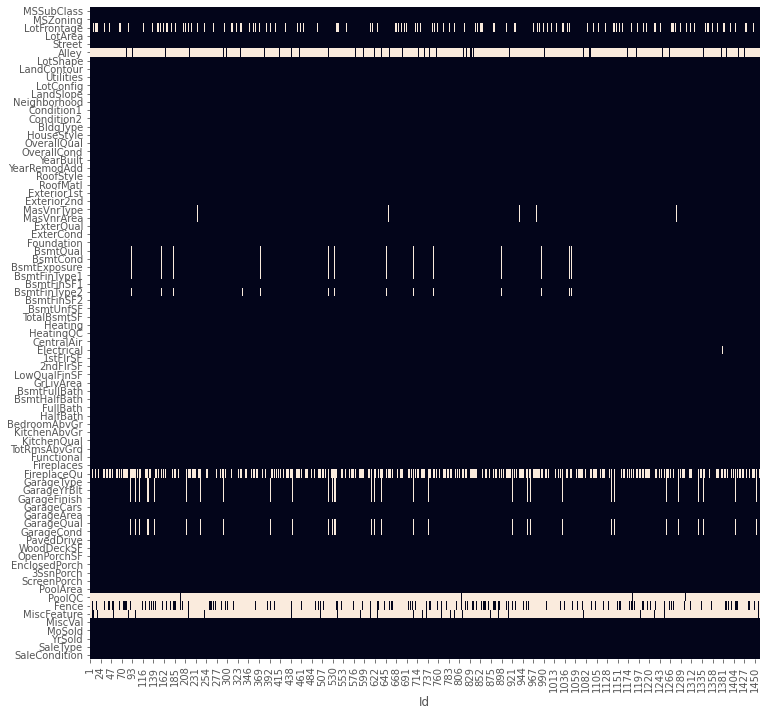

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(X.isna().T, yticklabels=True, ax=ax, cbar=False)

<AxesSubplot:xlabel='Id'>

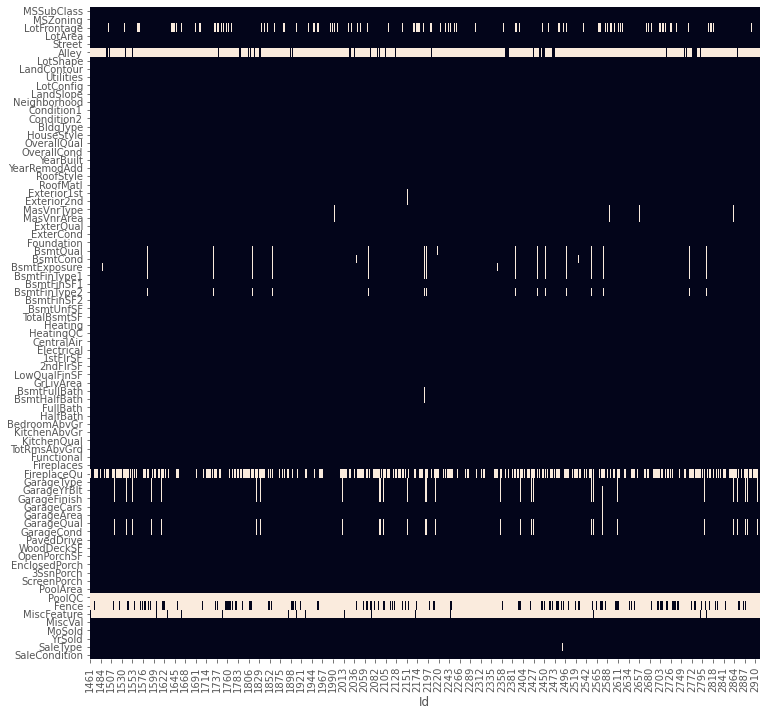

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(X_test.isna().T, yticklabels=True, ax=ax, cbar=False)

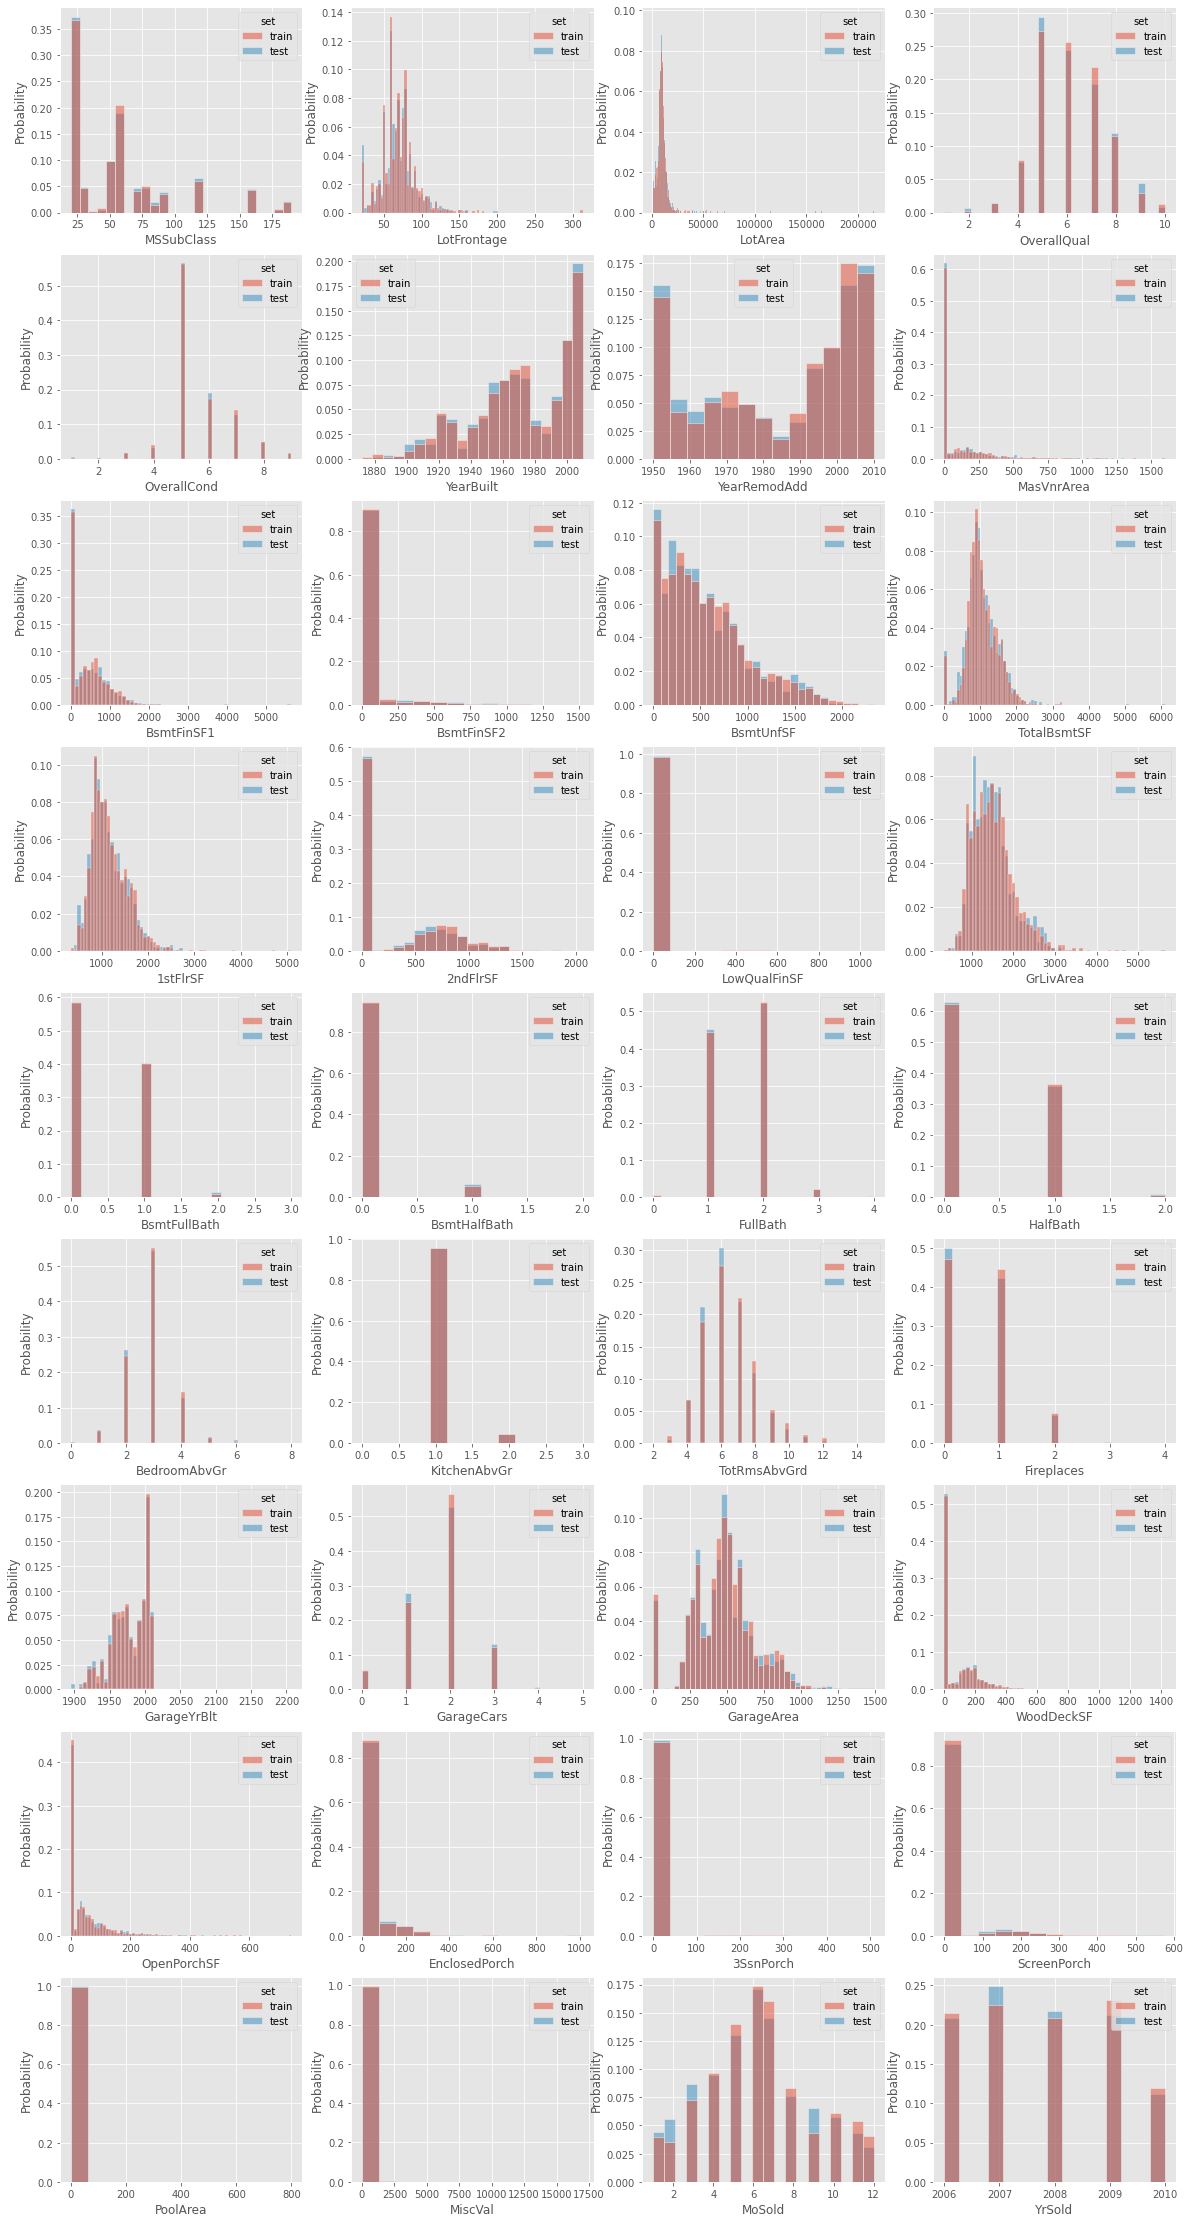

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=9, figsize=(20, 40))

for col, ax in zip(columns_num, axs.flat):
    sns.histplot(data=df_combined,
                 x=col,
                 hue='set',
                 stat='probability',
                 #multiple='dodge',
                 common_norm=False,
                 ax=ax)

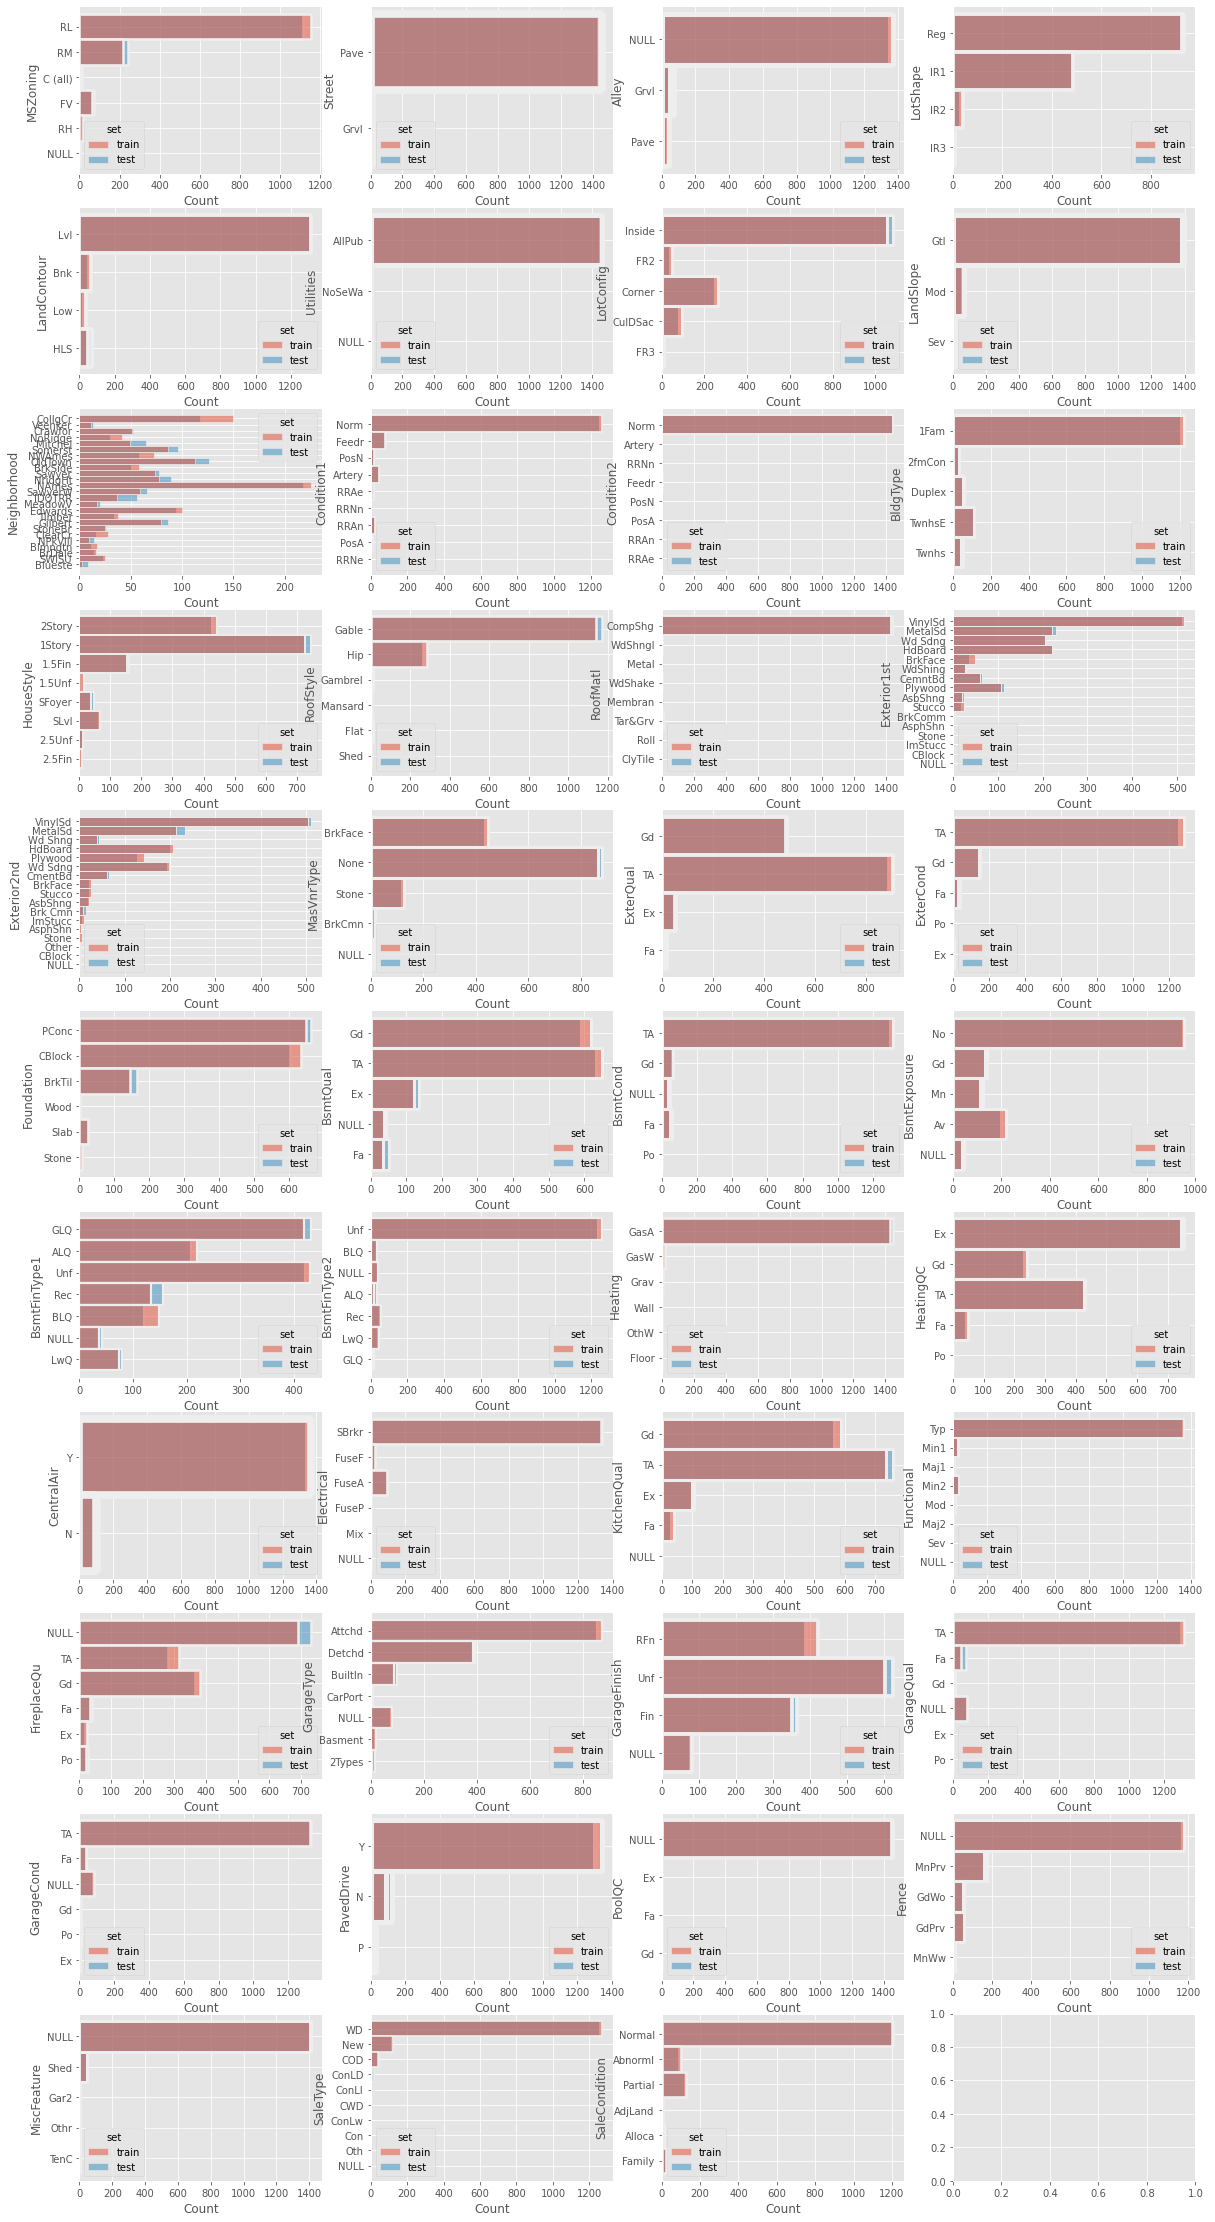

In [16]:
fig, axs = plt.subplots(ncols=4, nrows=11, figsize=(20, 40))

for col, ax in zip(columns_obj, axs.flat):
    sns.histplot(data=df_combined,
                 y=df_combined[col].fillna('NULL'),
                 hue='set',
                 ax=ax)

# Feature Preprocessing

## String --> Rate or Condition
Many features are categories which can be replaced with integers:
- Ex	Excellent -> 5
- Gd	Good -> 4
- TA	Typical/Average -> 3
- Fa	Fair -> 2
- Po	Poor -> 1
- NA	No Garage -> 0

In [17]:
dict_string2value = {
    'Street': {'Pave': 2, 'Grvl': 1},
    'Alley': {'Pave': 2, 'Grvl': 1, 'NULL':0}, # np.NaN: 0
    'LotShape': {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    'LandContour': {'Lvl':3, 'Bnk':2, 'HLS':1, 'Low':0},
    'Utilities': {"AllPub": 4, "NoSewr": 3, "NoSeWa":2, "ELO": 1, 'NULL':0}, # np.NaN: 0
    'LandSlope': {"Gtl": 3, "Mod": 2, "Sev": 1},
    "ExterQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
    "ExterCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}, 
    "BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "BsmtCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "BsmtExposure": {"Gd":4, "Av":3, "Mn":2, "No":1, 'NULL':0}, # np.NaN: 0
    "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "BsmtFinType2": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "HeatingQC": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
    "CentralAir": {"Y":1, "N":0},
    "Electrical": {"SBrkr":5, "FuseA":4, "FuseF":3, "FuseP":2, "Mix":1, 'NULL':0}, # np.NaN: 0
    "KitchenQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "Functional": {"Typ":8, "Min1":7, "Min2":6, "Mod":5, "Maj1":4, "Maj2":3, "Sev":2, "Sal":1, 'NULL':0}, # np.NaN: 0
    "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "GarageFinish": {"Fin":3, "RFn":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "GarageQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "GarageCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "PavedDrive": {"Y":2, "P":1, "N":0},
    "PoolQC":  {"Ex":4, "Gd":3, "TA":2, "Fa":1, 'NULL':0}, # np.NaN: 0
}

dict_na_1 = {
    "Alley":0,
    "Utilities":0,
    "BsmtQual":0,
    "BsmtCond":0,
    "BsmtExposure":0,
    "BsmtFinType1":0,
    "BsmtFinType2":0,
    "Electrical":0,
    "KitchenQual":0,
    "Functional":0,
    "FireplaceQu":0,
    "GarageFinish":0,
    "GarageQual":0,
    "GarageCond":0,
    "PoolQC":0,
}

# dict_1 = set(list(dict_string2value.keys())+list(dict_na_1.keys()))

def discrete_integer(X):
    #return X.replace(dict_string2value).fillna(dict_na_1)
    columns = list(dict_na_1.keys())
    X = X.copy()
    X[columns] = X[columns].fillna('NULL')
    return X.replace(dict_string2value)

def to_ordered_categories(X):
    X = X.copy()
    for k, v in dict_string2value.items():
        categories = list(v.values())
        X[k] = pd.Categorical(X[k], categories=categories, ordered=True)
    return X

ordered_categories = list(dict_string2value.keys())

df_combined_1 = discrete_integer(df_combined)
X_1 = discrete_integer(X)
X_test_1 = discrete_integer(X_test)

Box-plot to confirm that the value are in correct order (highest value is higher price)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


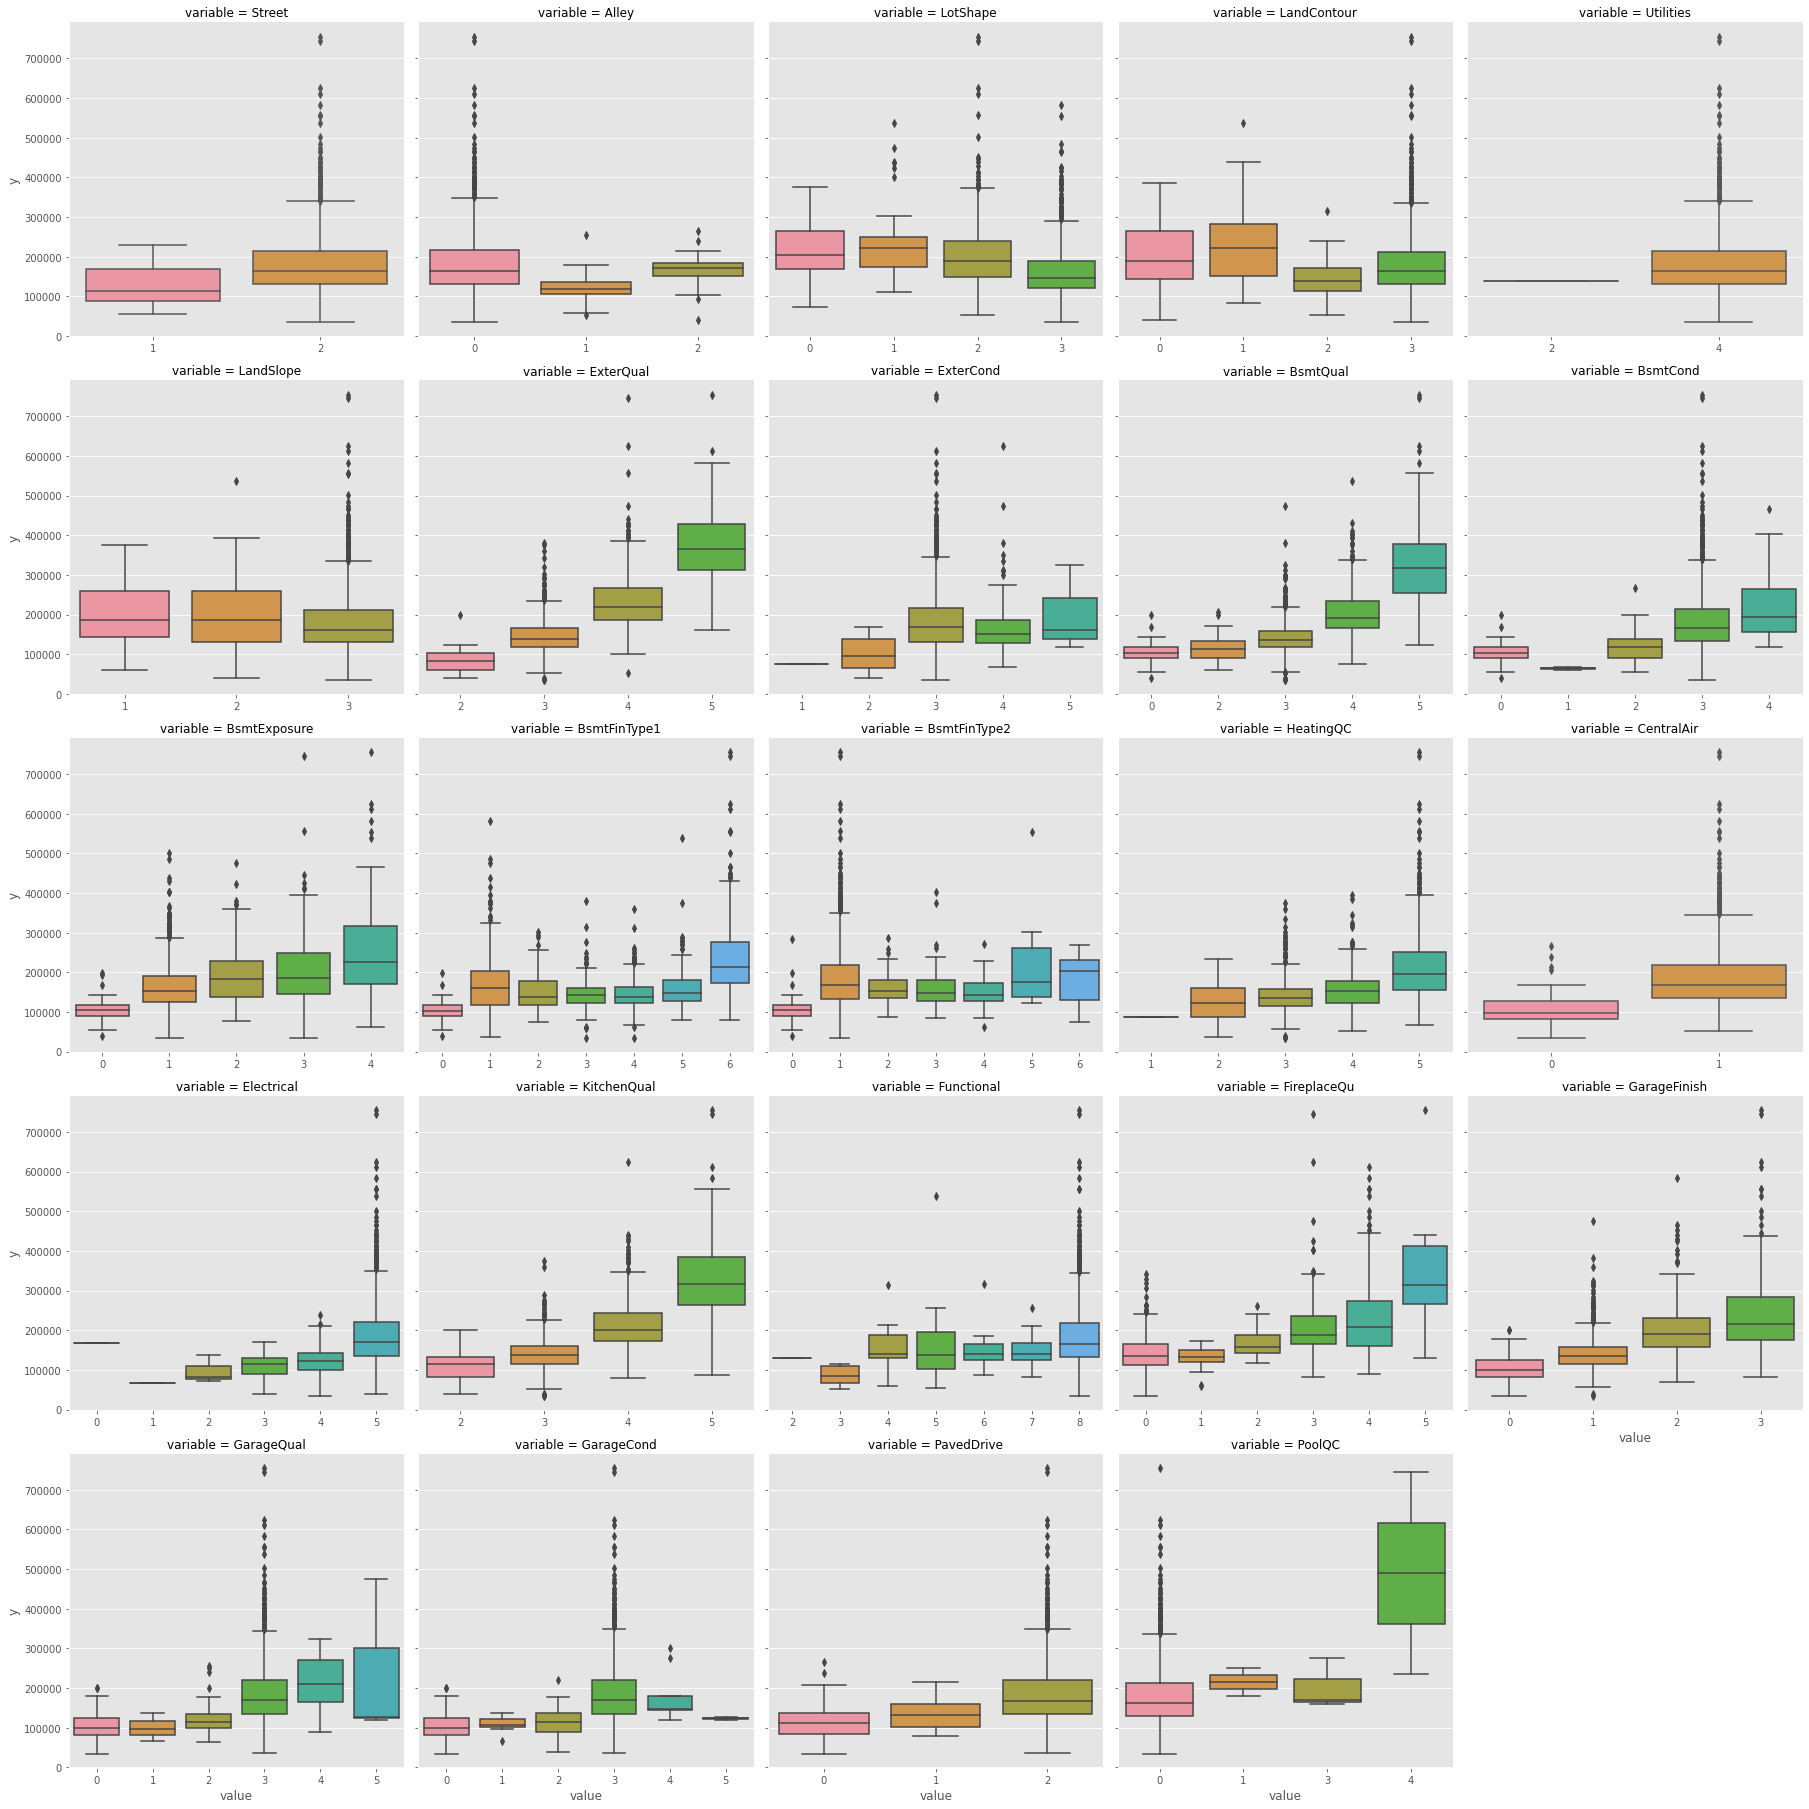

In [18]:
sns.catplot(data=X_1[dict_string2value].assign(y=y).melt(id_vars=['y']),
            x='value',
            col="variable",
            y='y',
            kind='box',
            sharex=False,
            col_wrap=5,
            height=5)

In [19]:
X_1[dict_string2value]\
    .corrwith(y)\
    .sort_values(ascending=False)\
    .to_frame()\
    .style\
    .bar(vmin=-1, align='zero', vmax=1)

Not all features correlate linearly with the target

## Data Cleaning

### NA in discrete columns

In [20]:
columns_na = df_combined.columns[(df_combined_1.isna().sum() > 0)].sort_values().tolist()
print(columns_na)

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'Exterior1st', 'Exterior2nd', 'Fence', 'GarageArea', 'GarageCars', 'GarageType', 'GarageYrBlt', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'SaleType', 'TotalBsmtSF']


It seems that some missing values could be replaced with 0 or "other" or "none"

We distinguish them between:
- numbers (example: *SF, *Area), we could replace NaN --> 0
- categories (example: Misc) we could replace NaN --> None
- categories (example: SaleType) we could replace NaN --> Other

In [21]:
df_combined_1[columns_na]\
    .apply('nunique')\
    .sort_values()\
    .to_frame(name='number of unique values')\
    .style\
    .bar()

In [22]:
columns_na_cat = df_combined_1[columns_na].apply('nunique').loc[lambda x: x<20].index

unique_values = pd.DataFrame(
    [[c, X_1[c].unique(),[x for x in X_test_1[c].unique() if not(x in X_1[c].unique())]]
      for c in columns_na_cat],
    columns=['column name', 'train unique values', 'other values in test']
).set_index('column name')

unique_values.join([X_1[columns_na_cat].isna().sum().rename('NA train'),
                    X_test_1[columns_na_cat].isna().sum().rename('NA test')]).style

We can notice wronly imputed category in some columns, such as:
- "Brk Cmn" which should be "Brk Comm"
- "CmentBd" which should be "CemntBd"
- "Wd Shng" which should be "WdShing"

The above columns with low NA value (and moreover if all in test) will be replaced by 0 or 'other', as it seems just that the data in test was not cleaned compared to train
Ther other above columns will be replaced by the category available in documentation such as "None" or "NA"

For the columns with an "Other" option which is never used, we will impute the value later.

In [23]:
columns_na_num = df_combined_1[columns_na].apply('nunique').loc[lambda x: x>=20].index

df_combined_1[columns_na_num].describe(include='all')

BsmtFinSF1   BsmtFinSF2    BsmtUnfSF   GarageArea  GarageYrBlt  \
count  2918.000000  2918.000000  2918.000000  2918.000000  2760.000000   
mean    441.423235    49.582248   560.772104   472.874572  1978.113406   
std     455.610826   169.205611   439.543659   215.394815    25.574285   
min       0.000000     0.000000     0.000000     0.000000  1895.000000   
25%       0.000000     0.000000   220.000000   320.000000  1960.000000   
50%     368.500000     0.000000   467.000000   480.000000  1979.000000   
75%     733.000000     0.000000   805.500000   576.000000  2002.000000   
max    5644.000000  1526.000000  2336.000000  1488.000000  2207.000000   

       LotFrontage   MasVnrArea  TotalBsmtSF  
count  2433.000000  2896.000000  2918.000000  
mean     69.305795   102.201312  1051.777587  
std      23.344905   179.334253   440.766258  
min      21.000000     0.000000     0.000000  
25%      59.000000     0.000000   793.000000  
50%      68.000000     0.000000   989.500000  
75%      80.000000   164.000000  1302.000000  
max     313.000000  1600.000000  6110.000000

In [24]:
dict_na_2_num = [
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "GarageArea",
    #"GarageYrBlt",
    #"LotFrontage",
    "MasVnrArea",
    "TotalBsmtSF",
]
dict_na_2_num = {k:0 for k in dict_na_2_num}

dict_na_2_other = {
    "BsmtFullBath": 0,
    "BsmtHalfBath": 0,
    # "Exterior1st": "Other"
    "Exterior2nd": "Other",
    "GarageCars": 0,
    "GarageType": "NA",
    "MasVnrType": "None",
    "MiscFeature": "NA", # "Elev" is never used
    "Fence":"NA",
}

def discrete_na(X):
    return X.fillna(dict_na_2_num).fillna(dict_na_2_other)

X_2 = discrete_na(X_1)
X_test_2 = discrete_na(X_test_1)
df_combined_2 = discrete_na(df_combined_1)

In [25]:
display(X_2\
    .loc[:, lambda x: x.isna().sum() > 0]\
    .describe(include='all'))

display(X_test_2\
    .loc[:, lambda x: x.isna().sum() > 0]\
    .describe(include='all'))

LotFrontage  GarageYrBlt
count  1201.000000  1379.000000
mean     70.049958  1978.506164
std      24.284752    24.689725
min      21.000000  1900.000000
25%      59.000000  1961.000000
50%      69.000000  1980.000000
75%      80.000000  2002.000000
max     313.000000  2010.000000

MSZoning  LotFrontage Exterior1st  GarageYrBlt SaleType
count      1455  1232.000000        1458  1381.000000     1458
unique        5          NaN          13          NaN        9
top          RL          NaN     VinylSd          NaN       WD
freq       1114          NaN         510          NaN     1258
mean        NaN    68.580357         NaN  1977.721217      NaN
std         NaN    22.376841         NaN    26.431175      NaN
min         NaN    21.000000         NaN  1895.000000      NaN
25%         NaN    58.000000         NaN  1959.000000      NaN
50%         NaN    67.000000         NaN  1979.000000      NaN
75%         NaN    80.000000         NaN  2002.000000      NaN
max         NaN   200.000000         NaN  2207.000000      NaN

### NA in numerical columns

In [26]:
X[['LotFrontage']].describe()

LotFrontage
count  1201.000000
mean     70.049958
std      24.284752
min      21.000000
25%      59.000000
50%      69.000000
75%      80.000000
max     313.000000

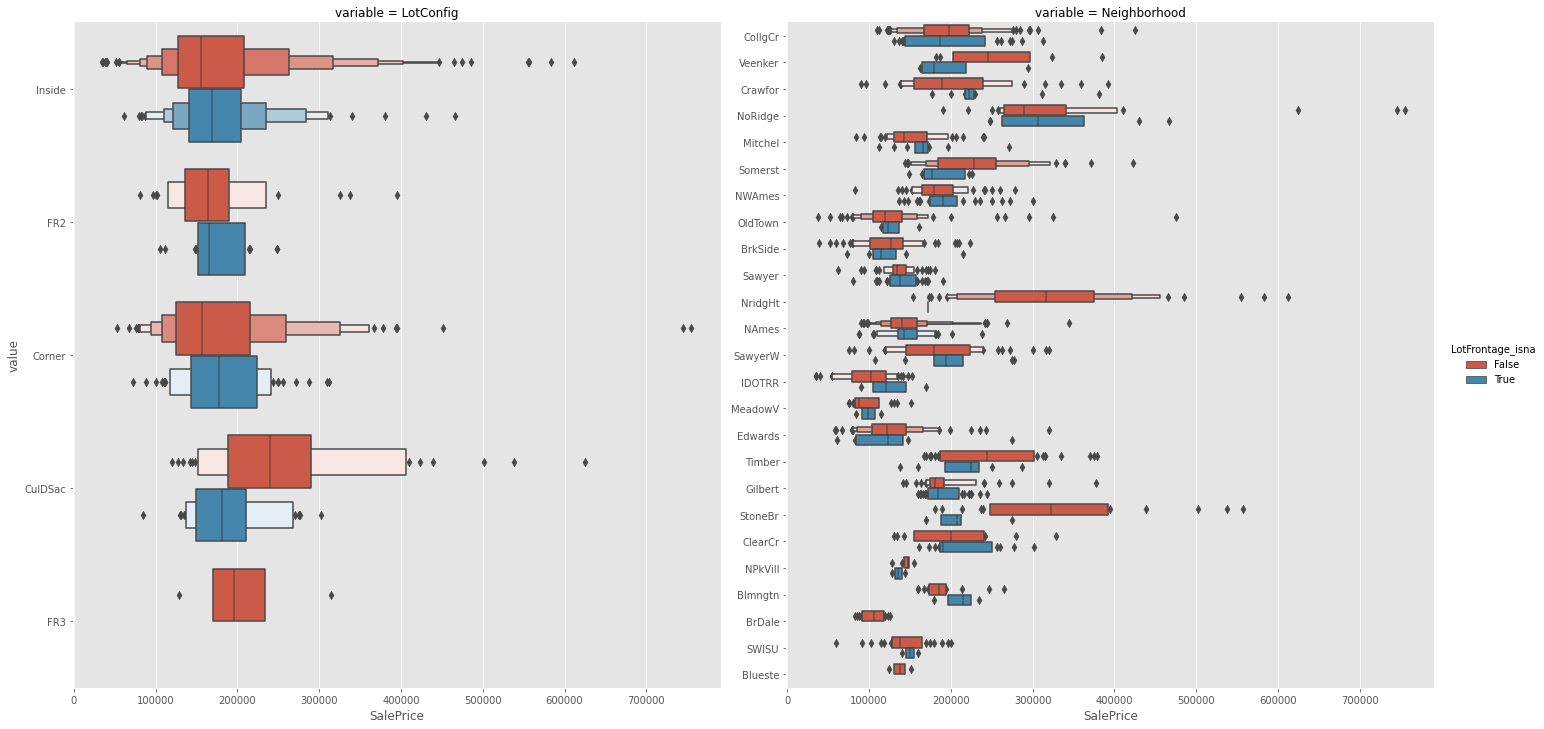

In [27]:
sns.catplot(
    data=df_train.assign(LotFrontage_isna=df_train.LotFrontage.isna())\
                 [['LotConfig', 'LotFrontage_isna', 'SalePrice', 'Neighborhood']]\
                 .melt(id_vars=['LotFrontage_isna', 'SalePrice']),
#     data=X.select_dtypes('object').assign(LotFrontage_isna=df_train.LotFrontage.isna(), SalePrice=y).melt(id_vars=['LotFrontage_isna', 'SalePrice']),
    y='value',
    #hue='LotFrontage_isna',
    x='SalePrice',
    col='variable',
    hue='LotFrontage_isna',
    #col_wrap=5,
    kind='boxen',
    sharey=False,
    sharex=True,
    height=10,
)

In [28]:
columns_isna_lotfrontage_different_top = ~(df_train.loc[df_train.LotFrontage.isna(), :].describe(include='object') == df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='object')).loc['top', :]
columns_isna_lotfrontage_different_top = columns_isna_lotfrontage_different_top[columns_isna_lotfrontage_different_top].index.tolist()
columns_isna_lotfrontage_different_top

['LotShape', 'Foundation', 'BsmtQual', 'BsmtFinType1', 'FireplaceQu']

In [29]:
# sns.catplot(
#     data=df_train.assign(LotFrontage_isna=df_train.LotFrontage.isna())[columns_isna_lotfrontage_different_top+['LotFrontage_isna', 'SalePrice']].melt(id_vars=['LotFrontage_isna', 'SalePrice']),
# #     data=X.select_dtypes('object').assign(LotFrontage_isna=df_train.LotFrontage.isna(), SalePrice=y).melt(id_vars=['LotFrontage_isna', 'SalePrice']),
#     x='value',
#     #hue='LotFrontage_isna',
#     y='SalePrice',
#     row='variable',
#     col='LotFrontage_isna',
#     #col_wrap=5,
#     kind='boxen',
#     sharex=False,
# )

In [30]:
columns_isna_lotfrontage_different_top = df_train.select_dtypes('number').columns[np.isclose(
    df_train.loc[df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    rtol=1e-3
)].tolist()
columns_isna_lotfrontage_different_top

['YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [31]:
# sns.catplot(
#     data=df_train[columns_isna_lotfrontage_different_top].assign(LotFrontage_isna=df_train['LotFrontage'].isna()).melt(id_vars='LotFrontage_isna'),
#     x='LotFrontage_isna',
#     y='value',
#     col='variable',
#     col_wrap=5,
#     kind='box',
#     sharey=False
# )

In [32]:
def numerical_na(X):
    return X.fillna({"LotFrontage":0})

### Wrong Categories

In [33]:
# columns_cat = df_combined_2\
#     .drop(columns='set')\
#     .apply('nunique')\
#     .loc[lambda x: x<20]\
#     .index

columns_cat = df_combined_2\
  .drop(columns='set')\
  .select_dtypes('object')\
  .columns

unique_values = pd.DataFrame(
    [[c, X_2[c].unique(),X_2[c].nunique(), [x for x in X_test_2[c].unique() if not(x in X_2[c].unique())]]
      for c in columns_cat],
    columns=['column name', 'train unique values', 'train n unique values', 'other values in test']
)

unique_values.set_index('column name').style

### Specific issue of Exterior2nd

In [34]:
X_2.query("Exterior1st=='Wd Sdng'")['Exterior2nd'].value_counts()

Wd Sdng    177
Wd Shng      9
Plywood      8
ImStucc      3
HdBoard      2
VinylSd      2
AsbShng      1
Stucco       1
Stone        1
BrkFace      1
MetalSd      1
Name: Exterior2nd, dtype: int64

In [35]:
X_2.query("Exterior1st=='WdShing'")['Exterior2nd'].value_counts()

Wd Shng    17
Plywood     5
HdBoard     2
Wd Sdng     1
Stucco      1
Name: Exterior2nd, dtype: int64

In [36]:
X_2.query("Exterior2nd=='Wd Shng'")['Exterior1st'].value_counts()

WdShing    17
Wd Sdng     9
VinylSd     5
Stucco      3
HdBoard     1
BrkFace     1
CemntBd     1
MetalSd     1
Name: Exterior1st, dtype: int64

For [Exterior1st, Exterior2nd], from the amount of:
- [Wd Sdng, Wd Sdng]
- [Wd Sdng, Wd Shng]
- [WdShing, Wd Shng]
I would say that "Wd Shng" --> "WdShing"

In [37]:
dict_clean_3 = {
    "Exterior2nd": {"CmentBd": "CemntBd",
                    "Brk Cmn":"BrkComm",
                    "Wd Shng": "WdShing"}
}

def wrong_categories(X):
    return X.replace(dict_clean_3)

X_3 = wrong_categories(X_2)
X_test_3 = wrong_categories(X_test_2)
df_combined_3 = wrong_categories(df_combined_2)

### Dates

In [38]:
df_combined_3[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe()

YearBuilt  YearRemodAdd  GarageYrBlt       YrSold
count  2919.000000   2919.000000  2760.000000  2919.000000
mean   1971.312778   1984.264474  1978.113406  2007.792737
std      30.291442     20.894344    25.574285     1.314964
min    1872.000000   1950.000000  1895.000000  2006.000000
25%    1953.500000   1965.000000  1960.000000  2007.000000
50%    1973.000000   1993.000000  1979.000000  2008.000000
75%    2001.000000   2004.000000  2002.000000  2009.000000
max    2010.000000   2010.000000  2207.000000  2010.000000

In [39]:
with pd.option_context('display.max_columns', None):
    display(df_combined[['YearBuilt', 'GarageYrBlt', 'YrSold', 'YearRemodAdd', 'set']].sort_values('GarageYrBlt', ascending=False).head(10))

YearBuilt  GarageYrBlt  YrSold  YearRemodAdd    set
Id                                                       
2593       2006       2207.0    2007          2007   test
1503       2010       2010.0    2010          2010   test
988        2009       2010.0    2010          2010  train
379        2010       2010.0    2010          2010  train
1609       2009       2010.0    2010          2010   test
820        2009       2010.0    2010          2010  train
645        2009       2009.0    2009          2009  train
516        2009       2009.0    2009          2009  train
573        2009       2009.0    2009          2009  train
582        2008       2009.0    2009          2009  train

In [40]:
df_combined_3\
    .query("GarageYrBlt<YearBuilt|YrSold<YearBuilt|YearRemodAdd<YearBuilt")\
    [['YearBuilt', 'GarageYrBlt', 'YrSold', 'YearRemodAdd', 'set']]\
    .assign(issue_Garage=lambda x: x['GarageYrBlt']<x['YearBuilt'])

YearBuilt  GarageYrBlt  YrSold  YearRemodAdd    set  issue_Garage
Id                                                                     
30         1927       1920.0    2008          1950  train          True
94         1910       1900.0    2007          1998  train          True
325        1967       1961.0    2010          2007  train          True
601        2005       2003.0    2006          2005  train          True
737        1950       1949.0    2006          1950  train          True
1104       1959       1954.0    2006          1959  train          True
1377       1930       1925.0    2008          1950  train          True
1415       1923       1922.0    2008          2000  train          True
1419       1963       1962.0    2008          1963  train          True
1522       1959       1956.0    2010          1959   test          True
1577       2010       2009.0    2010          2010   test          True
1806       1935       1920.0    2009          1998   test          True
1841       1978       1960.0    2009          1978   test          True
1877       2002       2002.0    2009          2001   test         False
1896       1941       1940.0    2009          1950   test          True
1898       1935       1926.0    2009          1950   test          True
2123       1945       1925.0    2008          1995   test          True
2264       2006       2005.0    2007          2007   test          True
2510       2006       2005.0    2007          2006   test          True
2550       2008       2008.0    2007          2009   test         False

In [41]:
X['GarageYrBlt'].isna().sum()

81

In [42]:
print('Nb of rows with no Garage', X['GarageQual'].isna().sum())
print('Nb of rows with GarageYrBlt==NaN', X['GarageYrBlt'].isna().sum())

Nb of rows with no Garage 81
Nb of rows with GarageYrBlt==NaN 81


I plan to add new features such as the difference in years instead of years

In [43]:
def wrong_dates(X_init):
    X = X_init.copy()

    # X.loc[X['YrSold'] < X['YearBuilt'], 'YrSold'] = X.loc[X['YrSold'] < X['YearBuilt'], 'YearBuilt']
    # X.loc[X['YearRemodAdd'] < X['YearBuilt'], 'YearRemodAdd'] = X.loc[X['YearRemodAdd'] < X['YearBuilt'], 'YearBuilt']
    # X.loc[X['GarageYrBlt'] < X['YearBuilt'], 'GarageYrBlt'] = X.loc[X['GarageYrBlt'] < X['YearBuilt'], 'YearBuilt']
    
    X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)
    X.loc[X['GarageYrBlt'] > 2010, 'GarageYrBlt'] = X.loc[X['GarageYrBlt'] > 2010, 'YearRemodAdd']
    return X

In [44]:
X['GarageYrBlt'].isna().sum()

81

## Preprocessing Summary

In [45]:
def preproc(X):
    return X.pipe(discrete_integer)\
            .pipe(discrete_na)\
            .pipe(wrong_categories)\
            .pipe(wrong_dates)\
            .pipe(to_ordered_categories)#\
            #.pipe(numerical_na)

In [46]:
X_pre = preproc(X)
X_test_pre = preproc(X_test)
df_combined_pre = preproc(df_combined)

In [47]:
X_pre['Utilities']

Id
1       4
2       4
3       4
4       4
5       4
       ..
1456    4
1457    4
1458    4
1459    4
1460    4
Name: Utilities, Length: 1460, dtype: category
Categories (5, int64): [4 < 3 < 2 < 1 < 0]

In [48]:
X_pre_cat_list = X_pre.select_dtypes('category').apply(lambda x: x.cat.categories)
X_test_pre_cat_list = X_test_pre.select_dtypes('category').apply(lambda x: x.cat.categories)

for column in X_pre_cat_list.index:
    same_category = X_pre_cat_list[column].equals(X_test_pre_cat_list[column])
    if same_category:
        print(column, 'OK')
    else:
        print(column, X_pre_cat_list[column], X_test_pre_cat_list[column])

Street OK
Alley OK
LotShape OK
LandContour OK
Utilities OK
LandSlope OK
ExterQual OK
ExterCond OK
BsmtQual OK
BsmtCond OK
BsmtExposure OK
BsmtFinType1 OK
BsmtFinType2 OK
HeatingQC OK
CentralAir OK
Electrical OK
KitchenQual OK
Functional OK
FireplaceQu OK
GarageFinish OK
GarageQual OK
GarageCond OK
PavedDrive OK
PoolQC OK


In [49]:
X_pre.nunique()\
    .rename('nunique')\
    .to_frame()\
    .join([X_pre.isna().sum().rename('isna'),
           X_pre.dtypes.rename('type'),
           X_test_pre.isna().sum().rename('isna test')])\
    .sort_values('nunique')\
    .style.bar()

In [50]:
columns_discrete = X.select_dtypes('object').columns.tolist()
columns_discrete = columns_discrete + ['MSSubClass', 'OverallQual', 'OverallCond']
columns_discrete, len(columns_discrete)

(['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',
  'HeatingQC',
  'CentralAir',
  'Electrical',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PavedDrive',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType',
  'SaleCondition',
  'MSSubClass',
  'OverallQual',
  'OverallCond'],
 46)

In [51]:
ordered_categories

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC']

# EDA Univariate

In [52]:
import statsmodels.api as sm
import scipy.stats as stats

## Target

Evaluation score is RMSE(log(y))

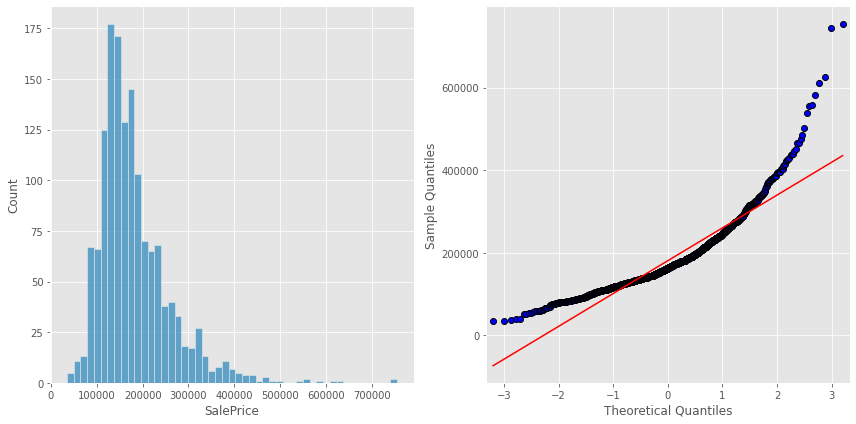

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(x=y, ax=axs[0])
sm.ProbPlot(y).qqplot(line='s', ax=axs[1], fmt='k')

plt.tight_layout()

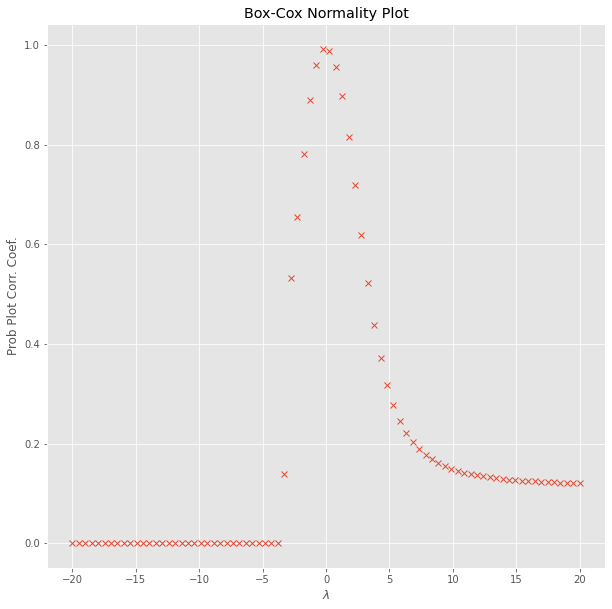

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
stats.boxcox_normplot(y, -20, 20, plot=ax)
plt.show()

In [55]:
maxlog = preprocessing.PowerTransformer().fit(y.to_frame()).lambdas_[0]
llf = stats.yeojohnson_llf(maxlog, y)

maxlog, llf

(-0.07693210208638519, -17423.60999924448)

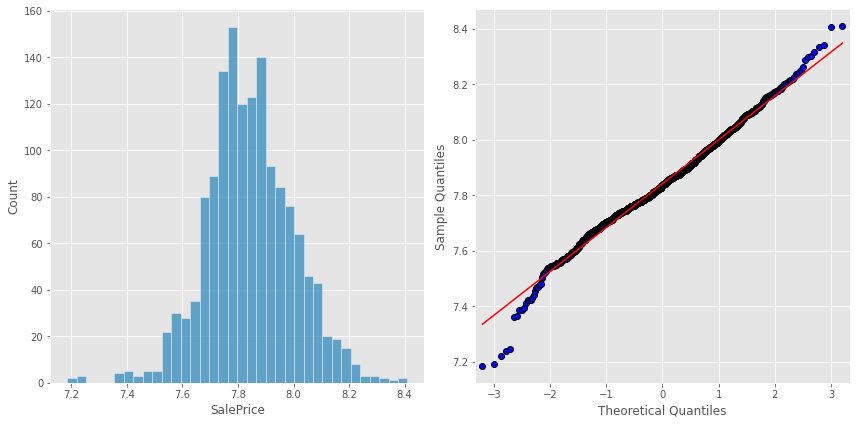

In [56]:
y_boxcox = preprocessing.PowerTransformer(method='box-cox', standardize=False).fit_transform(y.to_frame())
y_boxcox = pd.Series(y_boxcox[:,0], index=y.index, name=y.name)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(x=y_boxcox, ax=axs[0])
sm.ProbPlot(y_boxcox).qqplot(line='s', ax=axs[1], fmt='k')

plt.tight_layout()

Power transform normalize the target distribution
Let's use log(y) from now on

## Features

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1476: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1)

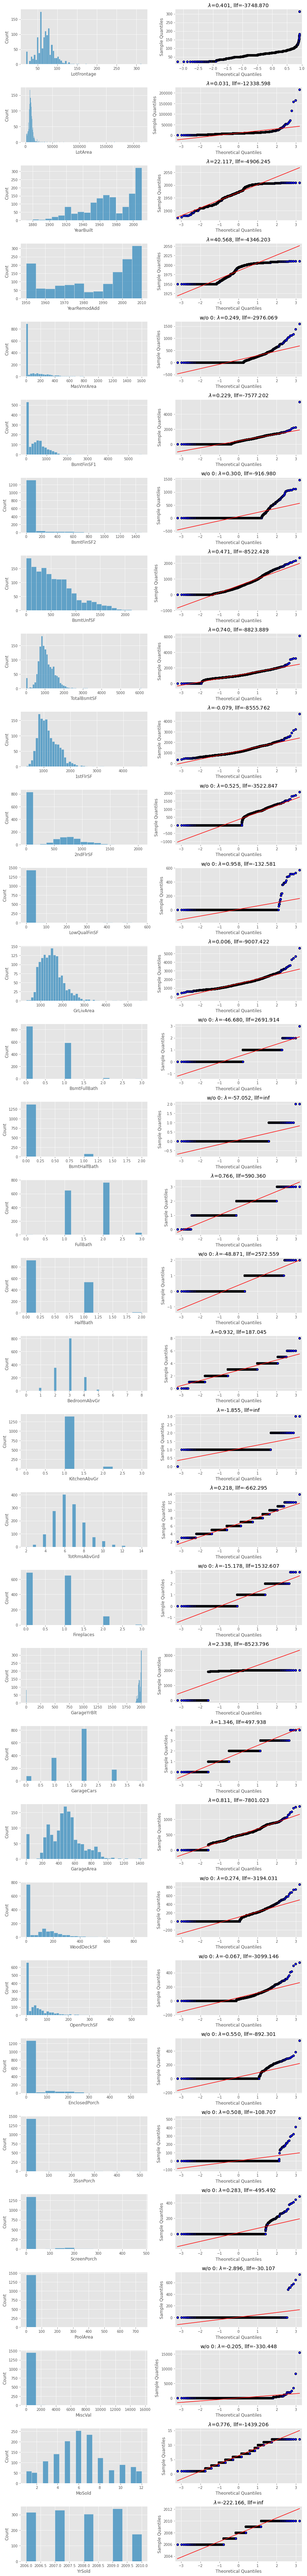

In [57]:
X_plot = X_pre.drop(columns=columns_discrete).select_dtypes('number')

fig, axs = plt.subplots(X_plot.shape[1], 2, figsize=(12, 100))

power_info = {"maxlog":{}, "llf":{}}

for i, c in enumerate(X_plot.columns):
    zero_skewed = (X_plot[c] == 0).sum() > (X_plot.shape[0] / 3)
    is_negative = X_plot[c].min() <= 0

    sns.histplot(x=X_plot[c], ax=axs[i, 0])
    sm.ProbPlot(X_plot[c]).qqplot(line='s', ax=axs[i, 1], fmt='k')

    if zero_skewed:
        x = X_plot[c].replace(0, np.NaN).dropna()
    else:
        x = X_plot[c].dropna()

    if is_negative:
        maxlog = preprocessing.PowerTransformer().fit(x.to_frame()).lambdas_[0]
        llf = stats.yeojohnson_llf(maxlog, x)
    else:
        maxlog = preprocessing.PowerTransformer(method='box-cox').fit(x.to_frame()).lambdas_[0]
        llf = stats.boxcox_llf(maxlog, x)
    power_info["maxlog"][c], power_info["llf"][c] = maxlog, llf

    if zero_skewed:
        axs[i, 1].set_title(f"w/o 0: $\lambda$={maxlog:.3f}, llf={llf:.3f}")
    else:
        axs[i, 1].set_title(f"$\lambda$={maxlog:.3f}, llf={llf:.3f}")

plt.tight_layout()

In [58]:
pd.DataFrame(power_info).sort_values("llf").style.background_gradient()

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


We can convert some features to a standard distributed feature (with a power transform)

It is called area_columns but contains `MiscValue` which is a price, converted to match `log(y)`

In [59]:
area_columns = X.columns[X.columns.str.contains('MiscVal|Area|SF|Porch$', case=True)]
len(area_columns)

18

In [60]:
X_pre[area_columns].describe(include='all')

LotArea   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count    1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    10516.828082   103.117123   443.639726    46.549315   567.240411   
std      9981.264932   180.731373   456.098091   161.319273   441.866955   
min      1300.000000     0.000000     0.000000     0.000000     0.000000   
25%      7553.500000     0.000000     0.000000     0.000000   223.000000   
50%      9478.500000     0.000000   383.500000     0.000000   477.500000   
75%     11601.500000   164.250000   712.250000     0.000000   808.000000   
max    215245.000000  1600.000000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   
mean   1057.429452  1162.626712   346.992466      5.844521  1515.463699   
std     438.705324   386.587738   436.528436     48.623081   525.480383   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.750000   882.000000     0.000000      0.000000  1129.500000   
50%     991.500000  1087.000000     0.000000      0.000000  1464.000000   
75%    1298.250000  1391.250000   728.000000      0.000000  1776.750000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000     0.000000   
max    1418.000000   857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal  
count  1460.000000  1460.000000   1460.000000  
mean     15.060959     2.758904     43.489041  
std      55.757415    40.177307    496.123024  
min       0.000000     0.000000      0.000000  
25%       0.000000     0.000000      0.000000  
50%       0.000000     0.000000      0.000000  
75%       0.000000     0.000000      0.000000  
max     480.000000   738.000000  15500.000000

In [61]:
def area_scaling(X):
    X = X.copy()
    area_columns = X.columns[X.columns.str.contains('MiscVal|Area|SF|Porch$', case=True)]
    X[area_columns] = preprocessing.power_transform(X[area_columns])
    return X

The features which describes an area can be standardized with PowerTransform

# Baseline model

## Baseline Processing

In [62]:
y_proc = np.log(y)

In [63]:
# columns_discrete, ordered_categories
columns_category = X.select_dtypes('object').columns.tolist() + ['MSSubClass']
columns_object = X_pre.select_dtypes('object').columns.tolist() + ['MSSubClass']
columns_numeric = X.drop(columns=columns_object).columns.tolist()
columns_object

['MSZoning',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'GarageType',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [64]:
def force_clean(X=X_pre, X_train=X_pre, final_imputer=True):
    X_clean = X.copy()
    X_train = X_train.copy()
    
    # Bug in sklearn 0.23 with SimpleImputer for categorical values (convert to numerical)
    #imputer = impute.SimpleImputer(strategy='most_frequent').fit(X_train[columns_category])
    #X_clean[columns_category] = imputer.transform(X_clean[columns_category])
    
    columns_object = X.select_dtypes('object').columns.tolist()
    # Temporary solution
    X_most_frequent = X_train[columns_object].apply(lambda x: x.mode()[0])
    X_train[columns_object] = X_train[columns_object].fillna(X_most_frequent)
    X_clean[columns_object] = X_clean[columns_object].fillna(X_most_frequent)
    
    encoder = preprocessing.OrdinalEncoder(dtype=int).fit(X_train[columns_object])
    X_train[columns_object] = encoder.transform(X_train[columns_object])
    X_clean[columns_object] = encoder.transform(X_clean[columns_object])
    
    X_train[columns_object] = X_train[columns_object].astype('category')
    X_clean[columns_object] = X_clean[columns_object].astype('category')
    
    if final_imputer:
        imputer = impute.KNNImputer().fit(X_train)
        X_nona = pd.DataFrame(imputer.transform(X_clean), index=X_clean.index, columns=X_clean.columns)
        X_clean = X_clean.fillna(X_nona)
    
    return X_clean

X_clean = force_clean(X_pre, X_pre)
X_clean_test = force_clean(X_test_pre, X_pre)

It is important to keep initial code values for MSSubClass (could it correlate more to target ?)

In [65]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Folds

In [66]:
#rng = np.random.RandomState(42)
rng = 42

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

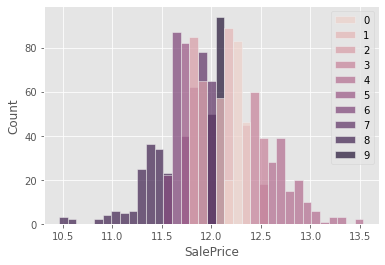

In [67]:
#y_encoded, _ = pd.cut(y_proc, 8).factorize()
y_encoded, _ = pd.qcut(y_proc, 10).factorize()
sns.histplot(x=y_proc, hue=y_encoded, multiple='stack')

In [68]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
y_encoded, _ = pd.qcut(y, q=10).factorize()

def get_folds(X_clean=X_clean, y=y_proc, y_encoded=y_encoded):
    #y_encoded = pd.qcut(preprocessing.power_transform(y.to_frame())[:, 0], q=20)
    #y_encoded = preprocessing.LabelEncoder().fit_transform(y_encoded)
    y_encoded, _ = pd.qcut(y, q=10).factorize()
    return folds.split(X_clean, y_encoded)

In [69]:
folds_index = pd.DataFrame(np.full((y.shape[0], 5), -1),
                           index=y.index,
                           columns=[f'fold{x}' for x in range(5)])

for i, (train_index, test_index) in enumerate(get_folds()):
    folds_index.iloc[train_index,i] = 0
    folds_index.iloc[test_index, i] = 1

folds_index.apply(lambda x: x.value_counts())

fold0  fold1  fold2  fold3  fold4
0   1168   1168   1168   1168   1168
1    292    292    292    292    292

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

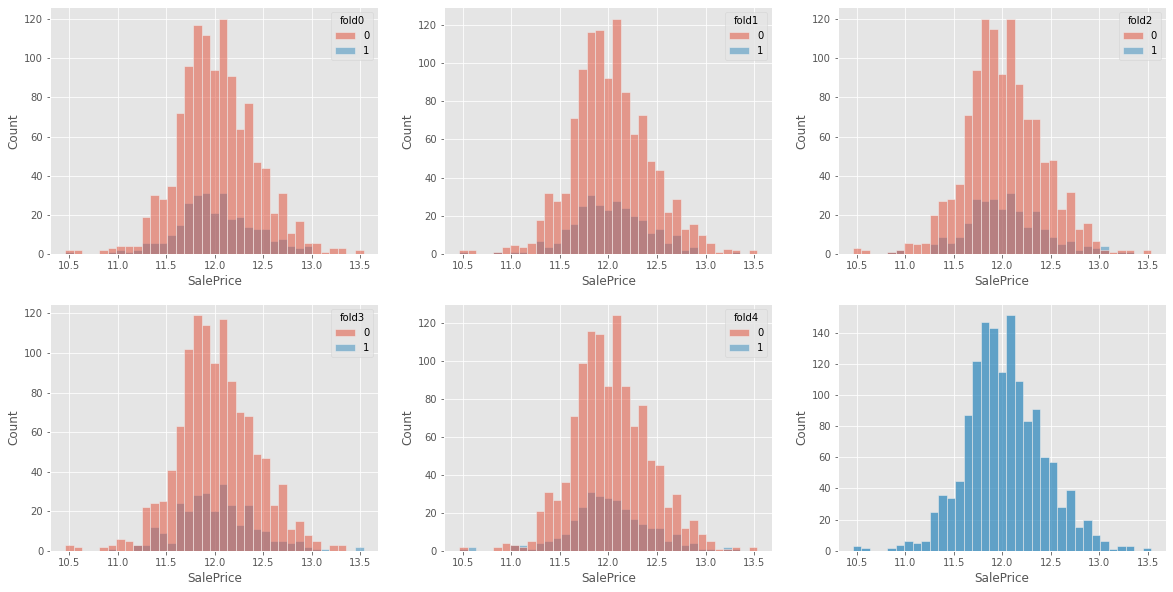

In [70]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flat

for i, c in enumerate(folds_index.columns):
    sns.histplot(x=y_proc,
                hue=folds_index.iloc[:, i],
                ax=axs[i])

sns.histplot(x=y_proc, ax=axs[5])

## Base Model

In [71]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

In [72]:
 cross_val_score(DummyRegressor(), X_clean, y_proc, cv=5, scoring='neg_root_mean_squared_error')

array([-0.3867785 , -0.4251402 , -0.40997109, -0.38299932, -0.39125229])

In [73]:
from sklearn.compose import make_column_selector

def score_models(X, y=y_proc, cv=None, clean=False, pipe=None, return_search=False, return_styled=True):
    
    if clean:
        X = force_clean(X, X)
    else:
        X = X.copy()
    
    if cv is None:
        y_encoded, _ = pd.qcut(y, q=10).factorize()
        cv = folds.split(X, y_encoded)
    
    models = [
        lgb.LGBMRegressor(objective="rmse", random_state=random_state, n_jobs=1),
        #SVR(),
        Ridge(),
        #ElasticNet(),
    ]
    
    estimator = Pipeline([("proc", pipe),
                          ("_dtype_", 'passthrough'),
                          ("model", DummyRegressor())])
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 eval_metric='rmse',
                                 random_state=random_state,
                                 #enable_categorical=True,
                                 n_jobs=1)
        
    # bugfix XGB<0.15 with `enable_categorical` parameter missing    
    def convert_cat_to_int(X):
        if not isinstance(X, pd.DataFrame):
            return X
        cat_cols = X.select_dtypes("category").columns
        X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
        return X
    
    transformer_cat_to_int = preprocessing.FunctionTransformer(convert_cat_to_int)
    
    param_grid = [{'_dtype_':['passthrough'], 'model':models},
                  {'_dtype_':[transformer_cat_to_int], 'model': [xgb_model]}]
    
    gscv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
        refit=False,
        cv=cv,
        error_score='raise',
        return_train_score=True,
    )
    gscv.fit(X, y)
    
    def convert_class_to_name(x):
        if isinstance(x, (str,int, float, bool)):
            return x
        else:
            return type(x).__name__

    r = pd.DataFrame(gscv.cv_results_)
    r = r.drop(r.filter(regex='^split|^params$|param__dtype_|rank_test_score|std_\w+_time|score_time', axis=1).columns, axis=1)
    r = r.applymap(convert_class_to_name).set_index("param_model").sort_index()
    r[['mean_train_score', 'mean_test_score']] *= -1
    
    if return_styled:
        r = r.style.bar(subset=['mean_fit_time', 'mean_train_score', 'mean_test_score'], vmin=0)
    
    if return_search:
        return (gscv, r)
    else:
        return r

In [74]:
score_models(X_clean)

In [75]:
base_score = score_models(X_clean, return_styled=False)

def test_new(*args, X=X_clean, pipe=None, return_styled=True, base_score=base_score):
    
    new_series = []    
    for i, new in enumerate(args):
        if isinstance(new, pd.Series):
            new = new.rename(f'new{i}')
        new_series.append(new)
        
    score = score_models(X.join(new_series), pipe=pipe, return_styled=False)
    
    r = base_score.add_prefix('base-').join(score.add_prefix('new-'))
    r = r.assign(diff_mean=r['new-mean_test_score'] - r['base-mean_test_score'],
                 diff_std=r['new-std_test_score'] - r['base-std_test_score'])
    if return_styled:
        r = r.style.bar(subset=['base-mean_fit_time',
                                'new-mean_fit_time',
                                'base-mean_train_score',
                                'new-mean_train_score',
                                'base-mean_test_score',
                                'new-mean_test_score'], vmin=0)
    return r

# Feature Engineering - Univariate

## Simple stuff

In [76]:
test_new(
    X_clean['GarageType'] == 0,
    X_clean['FireplaceQu'] == 0,
    X_clean['TotalBsmtSF'] == 0,
)

## Missing values trial
### LotFrontage

In [77]:
X_pre.isna().sum().loc[lambda x: x>0], X_test_pre.isna().sum().loc[lambda x: x>0]

(LotFrontage    259
 dtype: int64,
 MSZoning         4
 LotFrontage    227
 Exterior1st      1
 SaleType         1
 dtype: int64)

<AxesSubplot:xlabel='LotFrontage', ylabel='Count'>

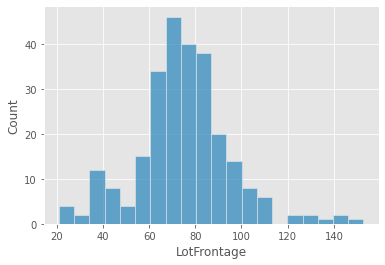

In [78]:
sns.histplot(X_clean['LotFrontage'].where(X_pre['LotFrontage'].isna()))

In [79]:
def test_lot_frontage(X_pre=X_pre):
    X_pre = X_pre.copy()
    X_pre[['LotFrontage']] = X_pre[['LotFrontage']].fillna(0)
    return test_new(X=force_clean(X_pre, X_pre))
test_lot_frontage()

In [80]:
from sklearn.linear_model import RidgeCV

y_lotfrontage = X_pre['LotFrontage']
X_lotfrontage = X_clean.drop(columns=['LotFrontage'])

y_lotfrontage_train = y_lotfrontage.dropna()
X_lotfrontage_train = X_lotfrontage.loc[~y_lotfrontage.isna(), :]
X_lotfrontage_test = X_lotfrontage.loc[y_lotfrontage.isna(), :]

lr_lotfrontage = RidgeCV().fit(X_lotfrontage_train, y_lotfrontage_train)
lot_frontage = X_pre['LotFrontage'].copy()
lot_frontage.loc[X_pre['LotFrontage'].isna()] = lr_lotfrontage.predict(X_lotfrontage_test)

test_new(X=X_clean.assign(LotFrontage=lot_frontage))

### Dates

In [81]:
def test_dates_missing(X_clean=X_clean, X=X):
    X = X.copy()
    X_clean = X_clean.copy()
    
    for col in ['YearRemodAdd', 'GarageYrBlt', 'YrSold']:
        X_clean.loc[X[col].isna(), col] = X_clean.loc[X[col].isna(), 'YearBuilt']
    
    return test_new(X=X_clean)

test_dates_missing()

## Cleaning in Pipeline

In [82]:
test_new(X=force_clean(X_pre, X_pre, final_imputer=False), pipe=impute.KNNImputer())

## Data Transformation (Power)

In [83]:
pipe_area = ColumnTransformer([('area', preprocessing.PowerTransformer(), area_columns)],
                              remainder='passthrough')
test_new(pipe=pipe_area)

In [84]:
pipe_area = ColumnTransformer([('area', preprocessing.FunctionTransformer(lambda x: np.sqrt(x+1)*(x!=0)), area_columns)],
                              remainder='passthrough')
test_new(pipe=pipe_area)

## Correlation (MI)

In [85]:
from sklearn.feature_selection import mutual_info_regression

def show_mi(X, y=y, clean=False):
    if clean:
        X = force_clean(X)
    
    columns_discrete = X.select_dtypes(['object', 'category'])
    discrete_features = X.columns.isin(columns_discrete)
    
    mi = mutual_info_regression(X, y,
                                random_state=random_state,
                                discrete_features=discrete_features)

    s = pd.Series(mi, index=X.columns, name='mutual_info_regression')\
          .sort_values(ascending=False)
          
    return s, s.to_frame().style.bar()

In [86]:
s_mi, mi = show_mi(X_clean)
mi

## Discard low correlation

In [87]:
X_mi = X_clean.loc[:, s_mi > 1e-4]
X_clean.columns.difference(X_mi.columns)

Index(['3SsnPorch', 'MiscFeature', 'MiscVal', 'MoSold', 'PoolQC', 'Utilities',
       'YrSold'],
      dtype='object')

In [88]:
test_new(X=X_mi)

## Summary

In [89]:
def proc_univariate(X=X_pre, X_train=X_pre):
    X = X.copy()
    #X[['LotFrontage']] = X[['LotFrontage']].fillna(0)
    X = force_clean(X, X_train)   
    
    s_mi, _ = show_mi(X)
    X = X.loc[:, s_mi > 1e-4]
    
    filtered_area_columns = X.columns.intersection(area_columns)
    sqrt_transform = preprocessing.FunctionTransformer(lambda x: np.sqrt(x+1)*(x!=0))
    pipe_area = ColumnTransformer([('area', sqrt_transform, filtered_area_columns)],
                                  remainder='passthrough')
    return test_new(X=X, pipe=pipe_area)

proc_univariate()

# EDA Multi-variate

## Feature Correlation

### Numerical

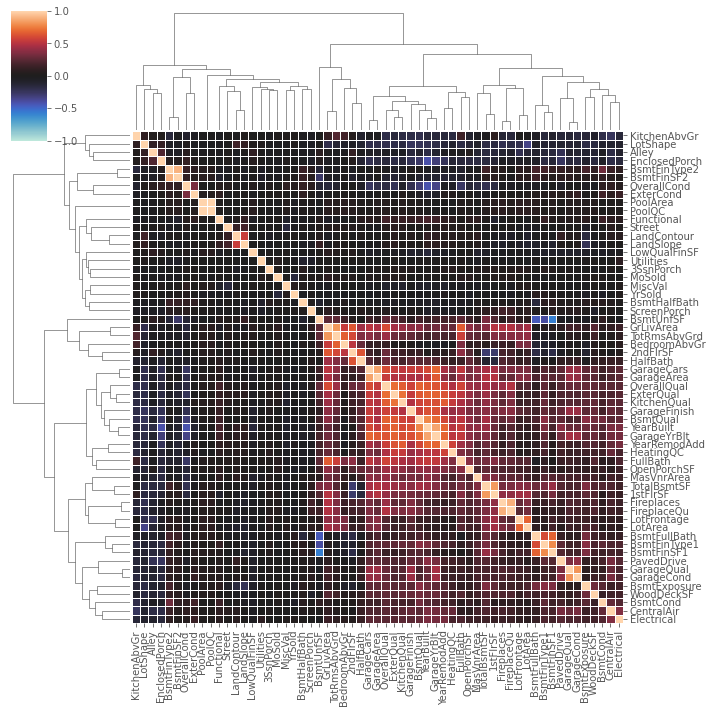

In [90]:
# columns_numeric = X_clean.select_dtypes(exclude='category').columns.tolist() + ordered_categories

X_corr_num = X_clean[columns_numeric].astype(float).corr(method='spearman')

sns.clustermap(
    X_corr_num,
    vmin=-1,
    vmax=1,
    cmap='icefire',
    method='complete',
    xticklabels=True,
    yticklabels=True,
    linewidths=1,
)

### Categorical / Numerical

1. https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
2. https://stats.stackexchange.com/questions/484299/how-to-check-the-correlation-between-categorical-and-numeric-independent-variabl
3. https://stats.stackexchange.com/questions/369783/how-to-do-a-correlation-matrix-with-categorical-ordinal-and-interval-variable
4. https://stats.stackexchange.com/questions/108007/correlations-with-unordered-categorical-variables
5. https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

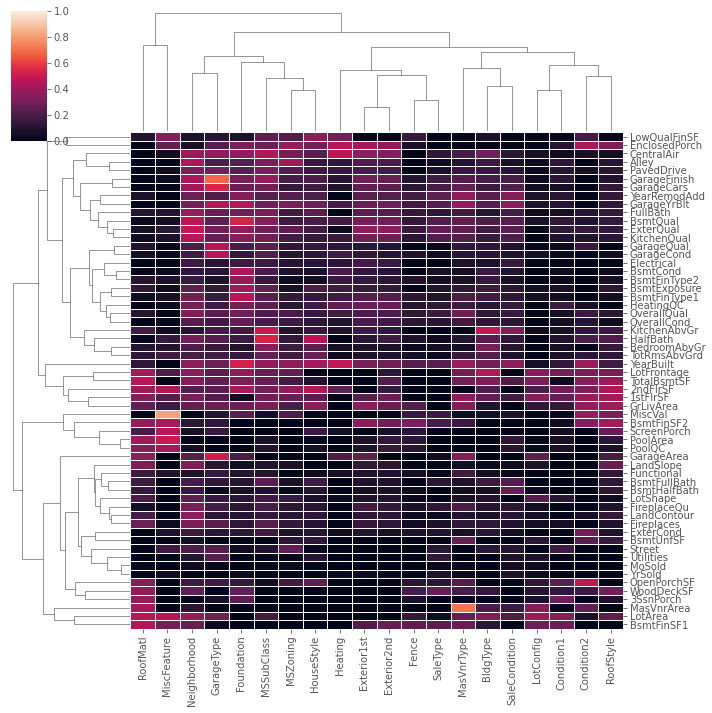

In [91]:
def cramers_corrected_stat(s1, s2):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(s1, s2)
    
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

X_corr_mix = X_clean.astype(float).corr(method=cramers_corrected_stat).loc[columns_numeric, columns_object]

sns.clustermap(
    X_corr_mix,
    vmin=0,
    vmax=1,
    #cmap='icefire',
    method='complete',
    xticklabels=True,
    yticklabels=True,
    linewidths=1,
)

### Category / Category

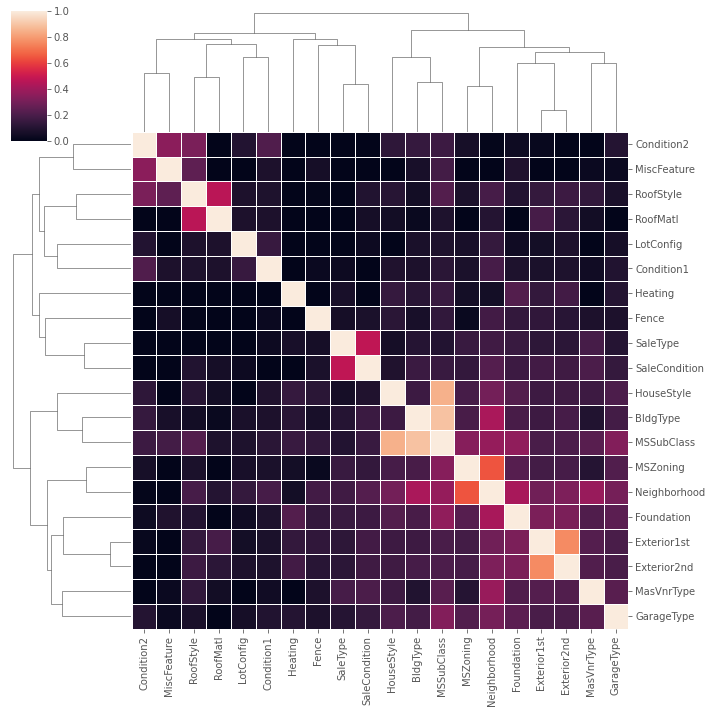

In [92]:
X_corr_cat = X_clean[columns_object].astype(int).corr(method=cramers_corrected_stat)

sns.clustermap(
    X_corr_cat,
    vmin=0,
    vmax=1,
    #cmap='icefire',
    method='complete',
    xticklabels=True,
    yticklabels=True,
    linewidths=1,
)

## Summary

In [93]:
s_mi.head(20).to_frame().style.bar(vmin=0, vmax=1)
# s_mi[:40].plot.bar(figsize=(12, 2), rot=45)
# s_mi.to_frame().T.style.background_gradient(axis=None, vmin=0, vmax=1)

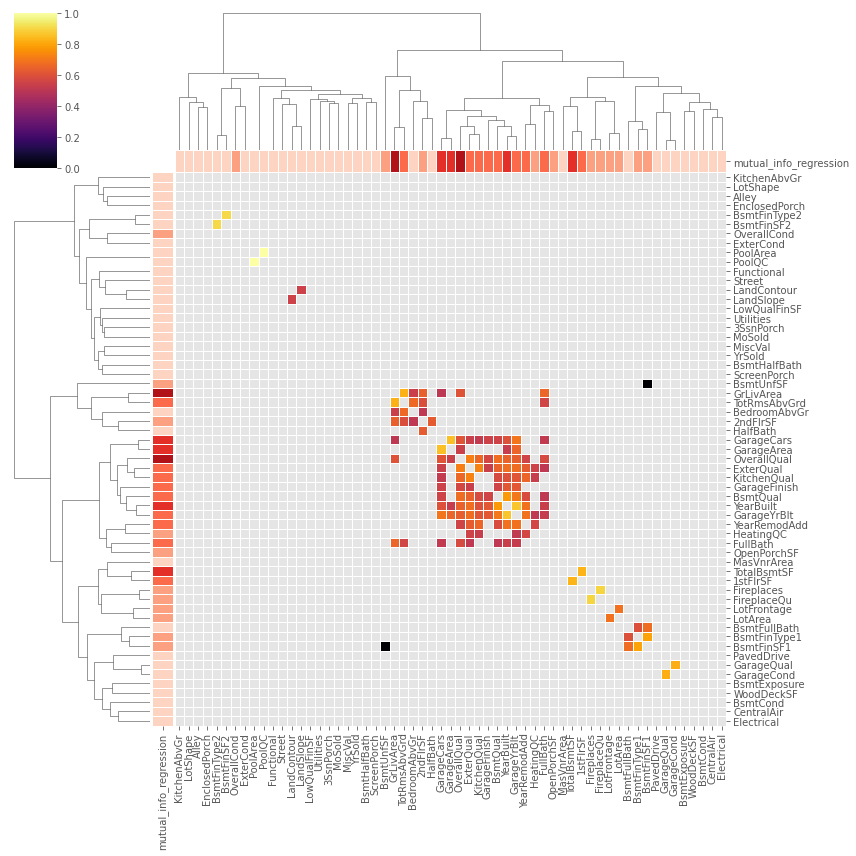

In [94]:
def smallest_corr(X, min_value=-1):
    X_mask = X.copy()
    if X.shape[0] == X.shape[1]:
        np.fill_diagonal(X_mask.values, np.nan)
    X_mask = X_mask.where(lambda x: x.abs() > min_value)
    
    X_small = X_mask.dropna(how='all', axis=0)\
                     .dropna(how='all', axis=1)\
                     .dropna(how='all', axis=0)
    
    q_mi = pd.cut(s_mi, bins=5, labels=False)
    mi_pal = sns.color_palette('Reds_r', len(q_mi.unique()))
    lut = dict(zip(q_mi.unique(), mi_pal))
    mi_colors = q_mi.map(lut)
    
    # return X_small.style.background_gradient(axis=None, cmap='magma', vmin=0, vmax=1)
    # return sns.clustermap(X_small.fillna(0), vmin=0, vmax=1, method='complete', row_colors=mi_colors, col_colors=mi_colors)
    return sns.clustermap(X, vmin=0, vmax=1, method='complete', mask=X_mask.isna(), xticklabels=True, yticklabels=True, linewidths=1, row_colors=mi_colors, col_colors=mi_colors, figsize=(12, 12), cmap='inferno')

smallest_corr(X_corr_num, 0.5)

In [95]:
X_corr_num.where(lambda x: x.abs() > 0.5).dropna(thresh=4, axis=0).index

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'HeatingQC', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea'],
      dtype='object')

In [96]:
test_new(
    X_clean.eval('GrLivArea / TotRmsAbvGrd'),
    #X_clean.eval('(`1stFlrSF` + `2ndFlrSF`) / TotRmsAbvGrd'),
    #X_clean.eval('GrLivArea / (FullBath+1)'),
    #X_clean.eval('GarageArea / (GarageCars+1)'),
    #X_clean.eval('BsmtFinSF1 / (BsmtFullBath+1)'),
    X_clean.eval('TotalBsmtSF - `1stFlrSF`'),
    #X_clean.eval('TotRmsAbvGrd - BedroomAbvGr'),
)

In [97]:
test_new(
    #X_clean.astype(int).eval('GarageQual * GarageCond'),
    #X_clean.astype(int).eval('Fireplaces * FireplaceQu'),
    #X_clean.astype(int).eval('PoolArea * PoolQC'),
    X_clean.eval('OverallQual * YearBuilt'),
)

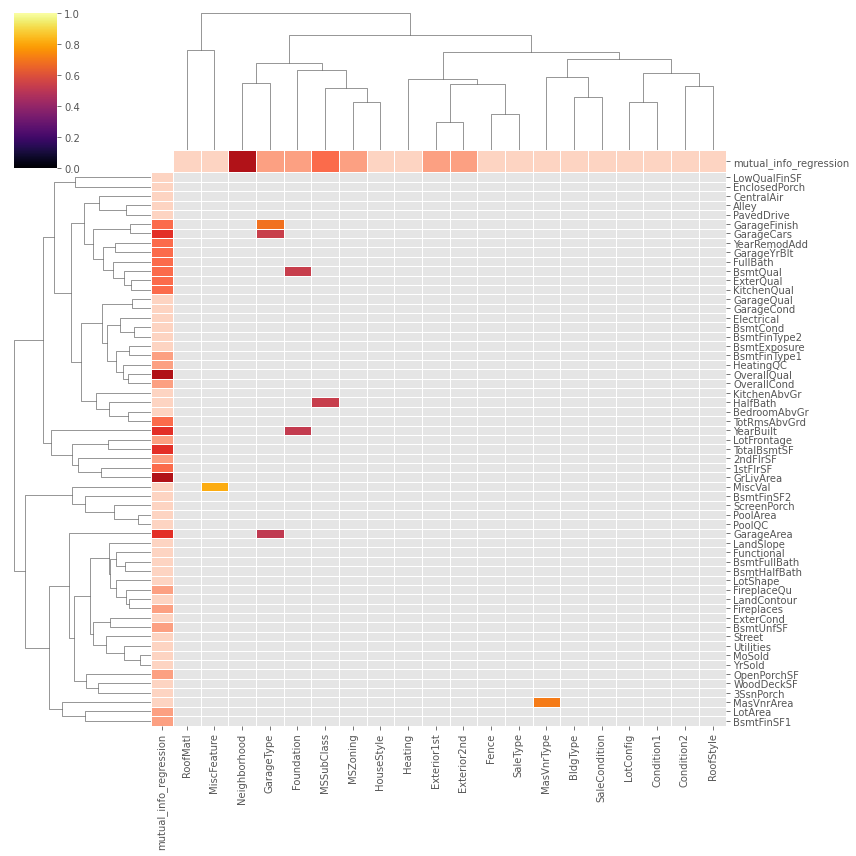

In [98]:
smallest_corr(X_corr_mix, 0.5)

In [99]:
test_new(
    pd.get_dummies(X_clean['GarageType']).mul(X_clean['GarageCars'], axis=0)
)

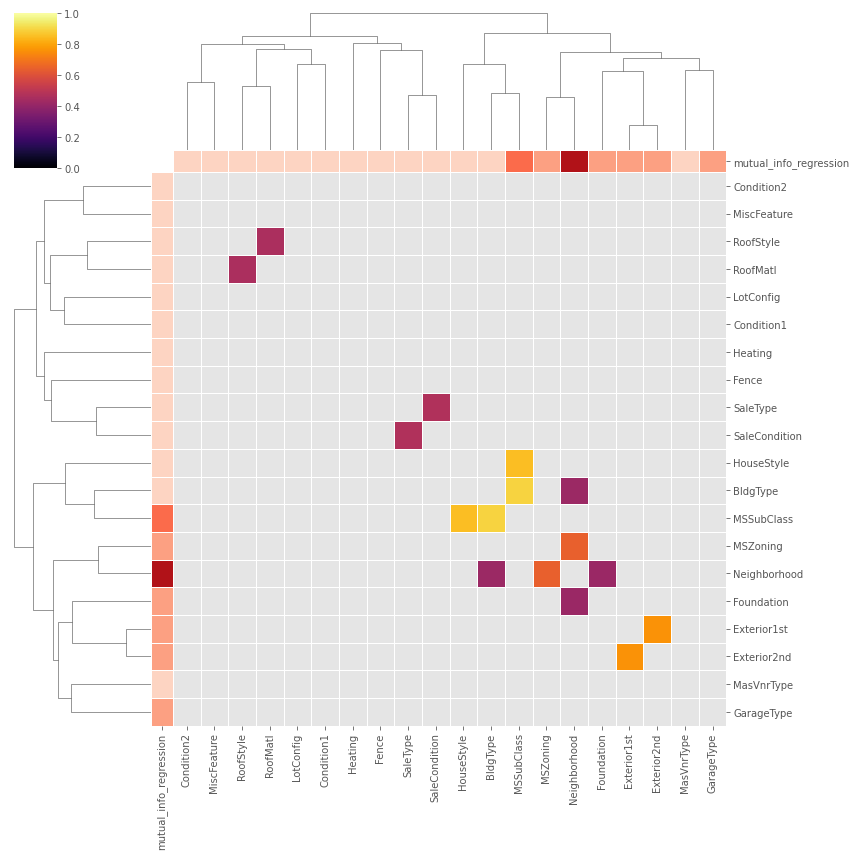

In [100]:
smallest_corr(X_corr_cat, 0.4)

## PCA

In [101]:
from sklearn.decomposition import PCA

def run_pca(columns=columns_numeric, X_clean=X_clean, s_mi=s_mi):
    X = X_clean.astype(float).transform(preprocessing.scale)
    #X = pd.DataFrame(X, columns=X_clean.columns, index=X_clean.index)
    pca = PCA(random_state=random_state).fit(X[columns])
        
    loadings = pd.DataFrame(pca.components_.T, index=X_clean[columns].columns)
    loadings = pd.concat([s_mi[columns], loadings], axis=1).sort_values(s_mi.name, ascending=False)
    
    X_pca = pd.DataFrame(pca.transform(X[columns]), index=X_clean.index)
    
    return pca, X_pca, loadings


def plot_pca(pca, X_pca, loadings):
    g = pd.DataFrame(pca.explained_variance_ratio_).plot.bar(figsize=(12, 6))
    s = loadings.style.bar(align='zero', vmin=-1, vmax=1)
    return g, s

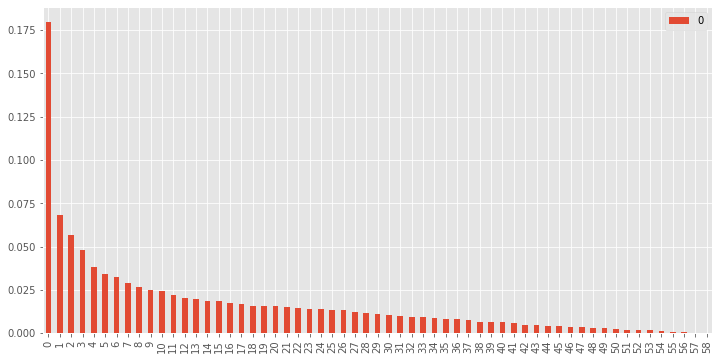

In [102]:
pca, X_pca, loadings = run_pca()
g, s = plot_pca(pca, X_pca, loadings)
g
display(s)

In [103]:
test_new(X=pd.concat([X_pca, X_clean.drop(columns=columns_numeric)], axis=1))

In [104]:
test_new(X_pca)

In [105]:
# for i in range(1, 10):
#     display(test_new(X_pca.iloc[:, 0:i]))
display(test_new(X_pca.iloc[:, 0]))

In [106]:
test_new(X_clean.astype(float).eval("(TotRmsAbvGrd+TotalBsmtSF)/(GrLivArea+`1stFlrSF`)")) # loading 52

In [107]:
test_new(X_clean.astype(float).eval("(FireplaceQu+Fireplaces)/YearBuilt"))

In [108]:
test_new(X_clean.astype(float).eval("BsmtQual*YearRemodAdd"))

# Feature Engineering - Multivariate

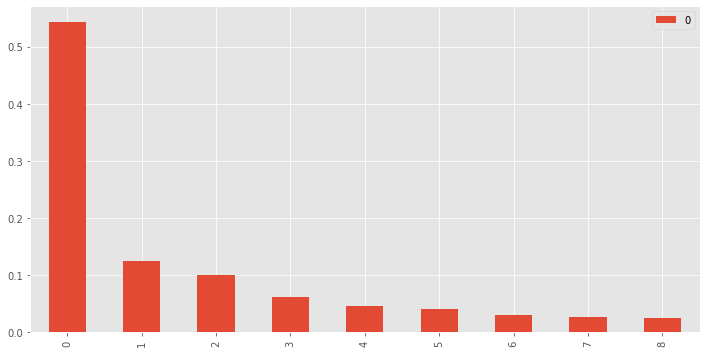

In [109]:
pca, X_pca, loadings = run_pca(X_corr_num.where(lambda x: x.abs() > 0.6).dropna(thresh=4, axis=0).index)
g, s = plot_pca(pca, X_pca, loadings)
s

In [110]:
#for i in range(1, 5):
#    display(test_new(X_pca.iloc[:, 0:i]))
    
test_new(X_pca.iloc[:, 0])

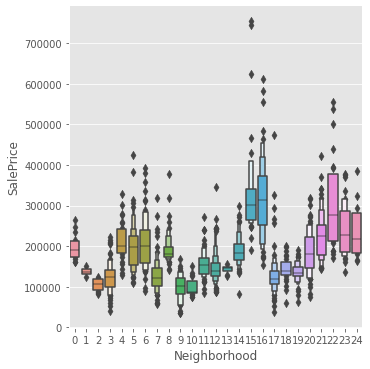

In [111]:
sns.catplot(data=X_clean, x='Neighborhood', y=y, kind='boxen')

In [112]:
test_new(
    X_clean.groupby('Neighborhood')['GrLivArea'].transform('mean'),
    #X_clean.groupby('Neighborhood')['GrLivArea'].transform('std'),
)

In [113]:
test_new(
    X_clean.groupby('Neighborhood')['GrLivArea'].transform('median'),
    #X_clean.groupby('Neighborhood')['GrLivArea'].transform('std'),
)

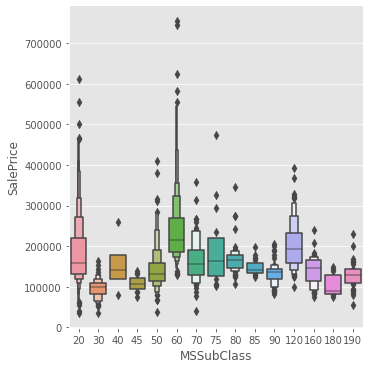

In [114]:
sns.catplot(data=X_clean, x='MSSubClass', y=y, kind='boxen')

In [115]:
test_new(
    X_clean.groupby('MSSubClass')['GrLivArea'].transform('mean'),
    #X_clean.groupby('MSSubClass')['LotArea'].transform('mean'),
)

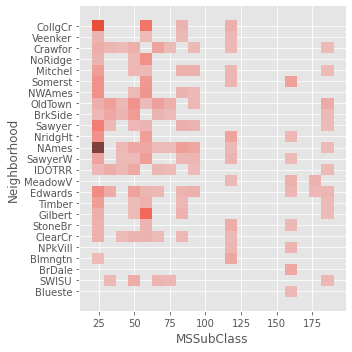

In [116]:
sns.displot(data=X_pre, y='Neighborhood', x='MSSubClass')

In [117]:
test_new(
    #X_clean.groupby(['MSSubClass', 'Neighborhood'])['LotArea'].transform('median'),
    X_clean.groupby(['MSSubClass', 'Neighborhood'])['GrLivArea'].transform('median'),
)

In [118]:
test_new(
    X_clean.groupby(['MSSubClass', 'Neighborhood', 'MSZoning'])['GrLivArea'].transform('mean'),
    X_clean.groupby(['MSSubClass', 'Neighborhood', 'MSZoning'])['LotArea'].transform('mean'),
)

In [119]:
test_new(
    #X_clean.groupby(['MSSubClass', 'Neighborhood', 'MSZoning'])['GrLivArea'].transform('median'),
    X_clean.groupby(['MSSubClass', 'Neighborhood', 'MSZoning'])['OverallQual'].transform(lambda x: x.mode()[0]),
)

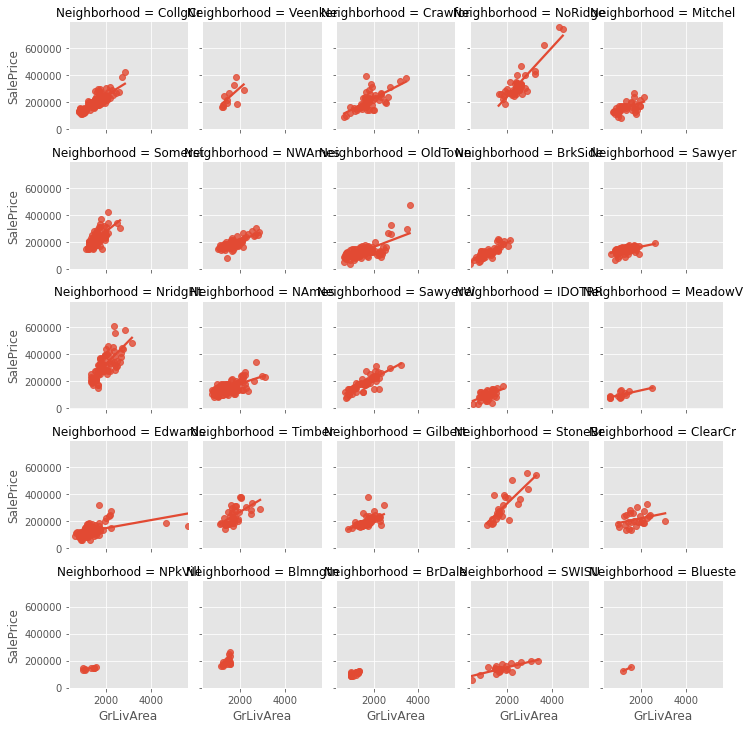

In [120]:
sns.lmplot(data=X_pre.join(y), x='GrLivArea', y='SalePrice', col='Neighborhood', ci=None, col_wrap=5, height=2)

In [121]:
from sklearn.linear_model import LinearRegression

lr_all = X_clean.join(y).groupby('Neighborhood', group_keys=False).apply(
    lambda x: pd.Series(LinearRegression().fit(x[['GrLivArea']], x['SalePrice']).predict(x[['GrLivArea']]), index=x.index)
)

test_new(lr_all)

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin

class ModelGroupBy(TransformerMixin):
    def __init__(self, model, cols, groupby_col, **model_kwargs):
        self.model_ = model
        if isinstance(cols, list):
            self.cols_ = cols
        elif isinstance(cols, str):
            self.cols_ = [cols]
        self.groupby_col_ = groupby_col
        self.model_kwargs_ = model_kwargs

    def fit(self, X, y):
        self.fitted_models_ = {}
        self.median_ = y.median()
        
        gb = X.join(y).groupby(self.groupby_col_, group_keys=False)
        for name, group in gb:
            group_x = group[self.cols_]
            group_y = group[y.name]
            self.fitted_models_[name] = self.model_(**self.model_kwargs_).fit(group_x, group_y)
        
        return self

    def transform(self, X):
        s_predict = []
        
        gb = X.groupby(self.groupby_col_, group_keys=False)
        for name, group in gb:
            group_x = group[self.cols_]
            if (name in self.fitted_models_.keys()) and group_x.shape[0] > 1:
                group_model = self.fitted_models_[name]
                values = group_model.predict(group_x)
            else:
                values = self.median_
            
            s = pd.Series(values, index=group.index, name=f'model_{self.groupby_col_}')
            s_predict.append(s)
            
        X_predict = pd.concat(s_predict)
        return X.join(X_predict)

In [123]:
(ModelGroupBy(LinearRegression, cols="GrLivArea", groupby_col='Neighborhood').fit_transform(X_clean, y).iloc[:, -1] == lr_all.sort_index()).all()

True

class is correct (result between one-liner and class for all index transformations is same)

In [124]:
pipe_lr = ModelGroupBy(LinearRegression, cols="GrLivArea", groupby_col='Neighborhood')
test_new(pipe=pipe_lr)

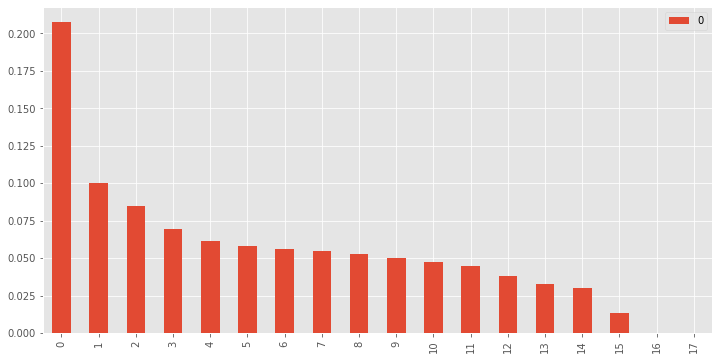

In [125]:
pca, X_pca, loadings = run_pca(area_columns)
g, s = plot_pca(pca, X_pca, loadings)
s

In [126]:
test_new(X_pca[[0]])

In [127]:
test_new(
#     X_clean.eval('(WoodDeckSF+OpenPorchSF+EnclosedPorch+`3SsnPorch`+ScreenPorch+PoolArea) / (LotArea+1)'), # External bonus area
    X_clean.eval('GrLivArea / LotArea'), # External / interior
    X_clean.eval('GrLivArea + TotalBsmtSF'), # External / interior
    #X_clean.eval('(`1stFlrSF`+`2ndFlrSF`) / (TotalBsmtSF+1)'),
    #X_clean.eval('MasVnrArea/(GarageArea+1)')
    #X_clean.eval('LotArea / (GrLivArea+TotalBsmtSF+GarageArea)'),
)

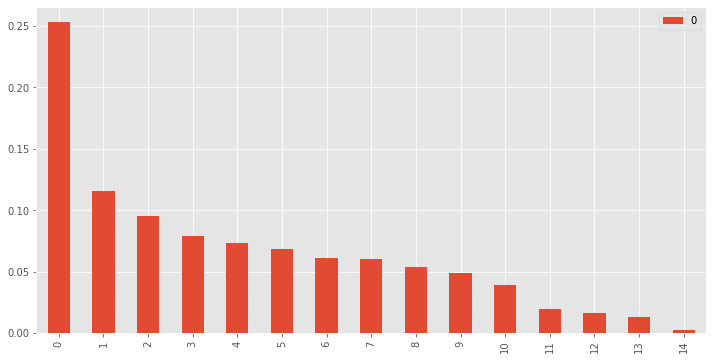

In [128]:
pca, X_pca, loadings = run_pca(X.filter(regex='Qual|Cond|PoolQC|FireplaceQu').columns)
g, s = plot_pca(pca, X_pca, loadings)
s

In [129]:
test_new(X_pca[0])

In [130]:
test_new(
    (X_clean[["BsmtQual", "FireplaceQu", "PoolQC", 'Fence', "MiscFeature", "Alley"]] != 0).astype(int).sum(axis=1)
)

In [131]:
test_new(
    #X_clean.eval("OverallCond/OverallQual"),
    X_clean.astype(float).eval("(Condition1+Condition2)/OverallCond"),
)

In [132]:
test_new(
    (X_clean[["BsmtQual", "FireplaceQu", "PoolQC", 'OverallQual', 'GarageQual']] != 0).astype(int).sum(axis=1)
)

## Target Encoder

In [133]:
from category_encoders import MEstimateEncoder

In [134]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [135]:
test_new(CrossFoldEncoder(MEstimateEncoder, m=1).fit_transform(X_clean, y, cols=["MSSubClass"]))

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [136]:
test_new(pipe=MEstimateEncoder(m=1, cols=['MSSubClass']))

In [137]:
test_new(CrossFoldEncoder(MEstimateEncoder, m=1).fit_transform(X_clean, y, cols=['Neighborhood']))

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [138]:
test_new(CrossFoldEncoder(MEstimateEncoder, m=1).fit_transform(X_clean, y, cols=['MSZoning']))

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Interaction + LassoCV

In [139]:
def scale_linear(X):
    X_num_scaled = X[columns_numeric].astype(float)
    X_cat_scaled = X[columns_object]
    
    X_num_scaled = preprocessing.scale(X_num_scaled)
    encoder = preprocessing.OneHotEncoder(sparse=False)
    X_cat_scaled = encoder.fit_transform(X_cat_scaled)
    
    X_num_scaled = pd.DataFrame(X_num_scaled, index=X.index, columns=columns_numeric)
    X_cat_scaled = pd.DataFrame(X_cat_scaled, index=X.index, columns=encoder.get_feature_names(columns_object))
    
    return X_num_scaled.join(X_cat_scaled)

scale_linear(X_clean)

LotFrontage   LotArea    Street     Alley  LotShape  LandContour  \
Id                                                                       
1       -0.248886 -0.207142  0.064238 -0.243025  0.701291     0.306146   
2        0.383214 -0.091886  0.064238 -0.243025  0.701291     0.306146   
3       -0.122466  0.073480  0.064238 -0.243025 -1.016637     0.306146   
4       -0.459586 -0.096897  0.064238 -0.243025 -1.016637     0.306146   
5        0.551774  0.375148  0.064238 -0.243025 -1.016637     0.306146   
...           ...       ...       ...       ...       ...          ...   
1456    -0.375306 -0.260560  0.064238 -0.243025  0.701291     0.306146   
1457     0.593914  0.266407  0.064238 -0.243025  0.701291     0.306146   
1458    -0.206746 -0.147810  0.064238 -0.243025  0.701291     0.306146   
1459    -0.122466 -0.080160  0.064238 -0.243025  0.701291     0.306146   
1460     0.172514 -0.058112  0.064238 -0.243025  0.701291     0.306146   

      Utilities  LandSlope  OverallQual  OverallCond  ...  MSSubClass_60  \
Id                                                    ...                  
1       0.02618   0.225716     0.651479    -0.517200  ...            1.0   
2       0.02618   0.225716    -0.071836     2.179628  ...            0.0   
3       0.02618   0.225716     0.651479    -0.517200  ...            1.0   
4       0.02618   0.225716     0.651479    -0.517200  ...            0.0   
5       0.02618   0.225716     1.374795    -0.517200  ...            1.0   
...         ...        ...          ...          ...  ...            ...   
1456    0.02618   0.225716    -0.071836    -0.517200  ...            1.0   
1457    0.02618   0.225716    -0.071836     0.381743  ...            0.0   
1458    0.02618   0.225716     0.651479     3.078570  ...            0.0   
1459    0.02618   0.225716    -0.795151     0.381743  ...            0.0   
1460    0.02618   0.225716    -0.795151     0.381743  ...            0.0   

      MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  \
Id                                                                 
1               0.0            0.0            0.0            0.0   
2               0.0            0.0            0.0            0.0   
3               0.0            0.0            0.0            0.0   
4               1.0            0.0            0.0            0.0   
5               0.0            0.0            0.0            0.0   
...             ...            ...            ...            ...   
1456            0.0            0.0            0.0            0.0   
1457            0.0            0.0            0.0            0.0   
1458            1.0            0.0            0.0            0.0   
1459            0.0            0.0            0.0            0.0   
1460            0.0            0.0            0.0            0.0   

      MSSubClass_90  MSSubClass_120  MSSubClass_160  MSSubClass_180  \
Id                                                                    
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   
5               0.0             0.0             0.0             0.0   
...             ...             ...             ...             ...   
1456            0.0             0.0             0.0             0.0   
1457            0.0             0.0             0.0             0.0   
1458            0.0             0.0             0.0             0.0   
1459            0.0             0.0             0.0             0.0   
1460            0.0             0.0             0.0             0.0   

      MSSubClass_190  
Id                    
1                0.0  
2                0.0  
3                0.0  
4                0.0  
5                0.0  
...              ...  
1456             0.0  
1457             0.0  
1458           

In [140]:
test_new(X=scale_linear(X_clean))

In [141]:
X_int = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X_clean)
X_int = pd.DataFrame(X_int, index=X_clean.index)
test_new(X=X_int)

In [142]:
X_clean_scaled = scale_linear(X_clean)

X_int = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X_clean_scaled)
X_int = pd.DataFrame(X_int, index=X_clean.index)
test_new(X=X_int)

In [143]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso

X_clean_scaled = scale_linear(X_clean)

interaction_transform = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False)
X_inter = interaction_transform.fit_transform(X_clean_scaled)
X_inter = pd.DataFrame(X_inter,
                       index=X_clean.index,
                       columns=interaction_transform.get_feature_names(X_clean_scaled.columns))

selecter = SelectFromModel(LassoCV(n_alphas=10, max_iter=10_000))
X_inter_select = selecter.fit_transform(X_inter, y_proc)
X_inter_select = pd.DataFrame(X_inter_select,
                              index=X_clean.index,
                              columns=X_inter.columns[selecter.get_support()])

In [144]:
X_inter.columns.shape, X_inter_select.columns.shape

((27028,), (348,))

In [145]:
s_inter_coef = pd.Series(selecter.estimator_.coef_, index=X_inter.columns, name='coef')\
                .drop(index=columns_numeric)\
                .sort_values(ascending=False)

s_inter_coef.head(20).to_frame().style.bar()

In [146]:
s_inter_mi, style_inter_mi = show_mi(X_inter_select, y=y_proc)
s_inter_mi.to_frame().head(40).style.bar()

In [147]:
test_new(X_inter_select.loc[:, s_inter_mi.drop(index=columns_numeric, errors='ignore').index])

In [148]:
X_inter_select_top = X_inter_select.loc[:, s_inter_mi.drop(index=columns_numeric, errors='ignore').head(20).index]

test_new(X_inter_select_top)

I add the intersections which have a better MI scores than there single counterparts

In [149]:
test_new(
    X_clean.astype(float).eval("OverallQual*KitchenQual"),
    #X_clean.astype(float).eval("OverallQual*BsmtQual"),
    X_clean.astype(float).eval("ExterQual*Fireplaces"),
    X_clean.astype(float).eval("CentralAir*GarageCars"),
    X_clean.astype(float).eval("TotalBsmtSF*KitchenAbvGr"),
    X_clean.astype(float).eval("ExterQual*FireplaceQu"),
    X_clean.astype(float).eval("FullBath*GarageYrBlt"),
    #X_clean.astype(float).eval("TotalBsmtSF*Condition2_2"),
    X_clean.astype(float).eval("TotalBsmtSF*Electrical"),
    X_clean.astype(float).eval("YearBuilt*CentralAir"),
    #X_clean.astype(float).eval("GarageCars*MiscFeature_1"),
    X_clean.astype(float).eval("BsmtQual*BsmtExposure"),
    X_clean.astype(float).eval("Alley*ExterQual"),
    X_clean.astype(float).eval("Street*GarageArea"),
    X_clean.astype(float).eval("ExterCond*GarageArea"),
    X_clean.astype(float).eval("LandContour*GarageArea"),
    X_clean.astype(float).eval("CentralAir*FullBath"),
    X_clean.astype(float).eval("LotShape*FullBath"),
    X_clean.astype(float).eval("ExterQual*ScreenPorch"),
    X_clean.astype(float).eval("BsmtHalfBath*KitchenQual"),
    X_clean.astype(float).eval("LandContour*BsmtQual"),
)

# Outliers

## From features

In [150]:
def z_outliers(X, X_train=X_clean):
    X_num = X.select_dtypes('number')

    q1 = X_num.quantile(1/4)
    q3 = X_num.quantile(3/4)
    iqr = q3 - q1

    is_outlier_matrix = (X_num < q1-1.5*iqr) | (X_num > q3+1.5*iqr)
    return is_outlier_matrix
    
is_outlier_matrix = z_outliers(X_clean)

test_new(is_outlier_matrix.sum(axis=1) > 0)

In [151]:
from sklearn.ensemble import IsolationForest

clf_outlier = IsolationForest(random_state=random_state).fit(X_clean.astype(float))

test_new(pd.Series(clf_outlier.predict(X_clean.astype(float)), index=X_clean.index))

## From target

https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions/data#outliers

<AxesSubplot:xlabel='SalePrice'>

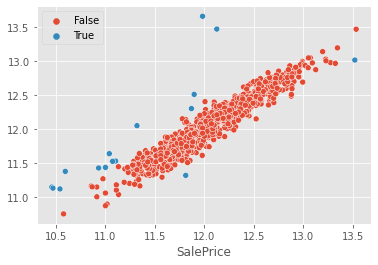

In [152]:
y_pred_lr = pd.Series(RidgeCV().fit(X_clean, np.log(y)).predict(X_clean), index=X_clean.index)
resid = np.log(y) - y_pred_lr

outliers = ((resid - resid.mean()) / resid.std()).abs() > 3
sns.scatterplot(x=np.log(y), y=y_pred_lr, hue=outliers)

In [153]:
test_new(outliers)

In [154]:
# def drop_outliers(X, y):
#     return X.drop(index=outliers[outliers].index, errors='ignore'), y.drop(index=outliers[outliers].index, errors='ignore')

# test_new(outliers, pipe=preprocessing.FunctionTransformer(drop_outliers))

# Processing Summary

Collection of individual best

In [155]:
# X_corr_num = X_clean[columns_numeric].astype(float).corr(method='spearman')

def test_proc(X=X_clean):
    X = X.copy()
    
    _, X_pca_all, _ = run_pca()
    _, X_pca_area, _ = run_pca(area_columns)
    #_, X_pca_num, _ = run_pca(X_corr_num.where(lambda x: x.abs() > 0.6).dropna(thresh=4, axis=0).index)
    
    new_columns = [
        (X[["BsmtQual", "FireplaceQu", "PoolQC", 'Fence', "MiscFeature", "Alley"]] != 0).astype(int).sum(axis=1),
        #X.eval('GrLivArea / LotArea'), # External / interior
        #X.eval('GrLivArea + TotalBsmtSF'), # External / interior
        #X.astype(float).eval("(FireplaceQu+Fireplaces)/YearBuilt"),
        #X.astype(float).eval("BsmtQual*YearRemodAdd"),
        X.groupby('Neighborhood')['GrLivArea'].transform('median'),
        X.eval("TotalBsmtSF * YearRemodAdd"), # Unknown origin
        #CrossFoldEncoder(MEstimateEncoder, m=1).fit_transform(X_clean, y, cols=['MSZoning']),
        X_pca_all[0],
        X_pca_area[0],
        #X_pca_num[0],
    ]
    
    s_mi, _ = show_mi(X, y=y_proc)
    X = X.loc[:, s_mi > 1e-4]
    
    filtered_area_columns = X.columns.intersection(area_columns)
    sqrt_transform = preprocessing.FunctionTransformer(lambda x: np.sqrt(x+1)*(x!=0))
    area_transform = ColumnTransformer([('area', sqrt_transform, filtered_area_columns)],
                                  remainder='passthrough')
    
    #lr_transform = ModelGroupBy(LinearRegression, cols="GrLivArea", groupby_col='Neighborhood')
    
    pipe = Pipeline([
        #('lr', lr_transform),
        ('me', MEstimateEncoder(m=1, cols=['MSZoning'])),
        ('area', area_transform)
    ]) 
        
    return test_new(*new_columns, X=X, pipe=pipe)

test_proc()

In [156]:
# (X_clean.replace(X_clean.groupby('MSSubClass')['GrLivArea'].agg('mean'))['MSSubClass'] == X_clean.groupby('MSSubClass')['GrLivArea'].transform('mean')).all()

I changed the order to add more coherence between the new features and the transformation. Changed area to "sqrt" and then calculate new features to keep same unit coherence.

In [157]:
from sklearn.feature_selection import mutual_info_regression

def show_mi(X, y=y, clean=False):
    if clean:
        X = force_clean(X)
    
    columns_discrete = X.select_dtypes(['object', 'category'])
    discrete_features = X.columns.isin(columns_discrete)
    
    mi = mutual_info_regression(X, y,
                                random_state=random_state,
                                discrete_features=discrete_features)

    s = pd.Series(mi, index=X.columns, name='mutual_info_regression')\
          .sort_values(ascending=False)
          
    return s, s.to_frame().style.bar()

In [158]:
def create_features(X=X_clean, X_train=X_clean, y=y_proc):
    X = X.copy()
    X_train = X_train.copy()
    
    # PCA - best column numerical
    #X_corr_num = X_train[columns_numeric].astype(float).corr(method='spearman')
    #best_num_columns = X_corr_num.where(lambda x: x.abs() > 0.6).dropna(thresh=4, axis=0).index
    
    # PCA - fit
    scaler_pca = preprocessing.StandardScaler()
    X_train_scaled = pd.DataFrame(scaler_pca.fit_transform(X_train.astype(float)[columns_numeric]), index=X_train.index, columns=columns_numeric)
    pca_all = PCA(random_state=random_state).fit(X_train_scaled[columns_numeric])
    pca_area = PCA(random_state=random_state).fit(X_train_scaled[area_columns])
    #pca_num = PCA(random_state=random_state).fit(X_train_scaled[best_num_columns])
    
    # PCA - transform
    X_scaled = pd.DataFrame(scaler_pca.transform(X.astype(float)[columns_numeric]), index=X.index, columns=columns_numeric)
    X_pca_all = pd.DataFrame(pca_all.transform(X_scaled[columns_numeric]), index=X.index)
    X_pca_area = pd.DataFrame(pca_area.transform(X_scaled[area_columns]), index=X.index)
    #X_pca_num = pd.DataFrame(pca_num.transform(X_scaled[best_num_columns]), index=X.index)
    
    # Transformer - ME
    m_encoder = MEstimateEncoder(m=1, cols=["MSZoning"])
    m_encoder.fit(X_train, y)
    X_encoded = m_encoder.transform(X)
    
    # # Transformer - 
    #lr = ModelGroupBy(LinearRegression, cols="GrLivArea", groupby_col='Neighborhood')
    #lr.fit(X_train, y)
    #X_lr = lr.transform(X)
    
    # Transformer - Area
    area_transform = preprocessing.FunctionTransformer(lambda x: np.sqrt(x+1)*(x!=0))
    #area_transform = preprocessing.PowerTransformer()
    area_transform.fit(X_train[area_columns])
    X[area_columns] = pd.DataFrame(area_transform.transform(X[area_columns]), index=X.index)
    
    encoded_1 = X_train.groupby('Neighborhood')['GrLivArea'].agg('median')
    
    new_series = [
        (X[["BsmtQual", "FireplaceQu", "PoolQC", 'Fence', "MiscFeature", "Alley"]] != 0).astype(int).sum(axis=1),
        #X.eval('GrLivArea / LotArea'), # External / interior
        #X.eval('GrLivArea + TotalBsmtSF'), # External / interior
        #X.astype(int).eval("(FireplaceQu+Fireplaces)/YearBuilt"),
        X.replace(encoded_1)['Neighborhood'], #X.groupby('Neighborhood')['GrLivArea'].transform('median'),
        #X.eval("TotalBsmtSF * YearRemodAdd"), # Unknown origin
        #CrossFoldEncoder(MEstimateEncoder, m=1).fit_transform(X_clean, y, cols=['MSZoning']),
        X_pca_all[0],
        X_pca_area[0],
        #X_pca_num[0],
        X_encoded.iloc[:, 0],
        #X_lr['model_Neighborhood']
    ]
    
    s_mi, _ = show_mi(X_train)
    X = X.loc[:, s_mi > 1e-4]
    #print(s_mi[~(s_mi > 1e-4)]) # Utilities, MiscVal, MiscFeatures, 3SsnPorch, MoSold, MiscVal, PoolQC
    
    X = X.join([s.rename(f'new_{i}') for i, s in enumerate(new_series)])
    
    return X

test_new(X=create_features())

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## from the raw data

In [159]:
X_pre = preproc(X)
X_test_pre = preproc(X_test)

X_clean = force_clean(X_pre, X_pre)
X_clean_test = force_clean(X_test_pre, X_pre)

X_proc = create_features(X_clean, X_clean)
X_proc_test = create_features(X_clean_test, X_clean)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [160]:
# columns_proc_category = X_proc.columns[X_proc.columns.isin(columns_category)]
# columns_proc_ordinal = X_proc.drop(columns=columns_proc_category).select_dtypes('category').columns
# columns_proc_numeric = X_proc.select_dtypes('number').columns

columns_proc_category = X_proc.drop(columns=columns_numeric, errors='ignore').columns
columns_proc_numeric = columns_numeric

In [161]:
X_proc_test.isna().sum().loc[lambda x: x>0]

Series([], dtype: int64)

In [162]:
score_models(X=X_proc)

### Outliers processing

In [163]:
score_models(X=X_proc.loc[~outliers, :], y=y_proc.loc[~outliers])

It seems interesting to drop outliers to avoid data noise in the training process...

In [164]:
# X_proc = X_proc.loc[~outliers, :]
# y_proc = y_proc.loc[~outliers]

In [165]:
y_encoded, _ = pd.qcut(y_proc, q=10).factorize()

def get_folds(X=X_proc, y=y_proc, y_encoded=y_encoded):
    y_encoded, _ = pd.qcut(y, q=10).factorize()
    return folds.split(X, y_encoded)

# Modeling

In [166]:
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import LinearSVR

## Model Selection
- LightGBM for sure
- ElasticNet as the linear model (different outputs)
- 3rd one choice: MLP ?

Then stacking with RF

In [167]:
def scale(X, X_train=X_proc):
    X_norm = X.drop(columns=columns_proc_category)
    X_train_norm = X_train.drop(columns=columns_proc_category)
    
    #boxcox = preprocessing.PowerTransformer()
    #X_train_boxcox = boxcox.fit_transform(X_train.drop(columns=columns_proc_category))
    scaler = preprocessing.StandardScaler().fit(X_train_norm)
    
    X_norm = pd.DataFrame(scaler.transform(X_norm), columns=X_norm.columns, index=X_norm.index)
    
    #X_norm = X_norm.join(pd.get_dummies(X[columns_proc_category]))
    encoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X_train[columns_proc_category])
    X_norm = X_norm.join(pd.DataFrame(encoder.transform(X[columns_proc_category]),
                                      columns=encoder.get_feature_names(columns_proc_category),
                                      index=X.index))
    return X_norm

X_proc_norm = scale(X_proc)
X_proc_norm_test = scale(X_proc_test)
print('any NaN ?', X_proc_norm.isna().any(axis=None))

any NaN ? False


In [168]:
# model = MLPRegressor(hidden_layer_sizes=(100, 1000, 100), random_state=random_state, max_iter=10_000, solver='adam', activation='tanh', early_stopping=True)

# r = cross_val_score(model, X_proc_norm, y_proc,
#                     cv=folds.split(X_proc, y_encoded),
#                     scoring='neg_root_mean_squared_error')
# print(-r.mean()) # 0.3871994246713676

In [169]:
model_selection_dict = {
    "LGBM": lgb.LGBMRegressor(objective="rmse", random_state=random_state),
    "XGB": xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=random_state),
    "RandomForest": RandomForestRegressor(random_state=random_state),
    "ExtraTrees": ExtraTreesRegressor(random_state=random_state, bootstrap=True),
    "SVR": SVR(),
    #"SVR_linear": LinearSVR(max_iter=10_000),
    "ElasticNet": ElasticNet(max_iter=10_000, random_state=random_state), 
    "Ridge": Ridge(),
}
model_selection_score = {}

for name, model in model_selection_dict.items():
    if name in ['SVR']:
        x = X_proc_norm
    elif name == 'XGB':
        x = X_proc.copy()
        columns_proc_category = x.select_dtypes('category').columns
        x[columns_proc_category] = x[columns_proc_category].astype(int)
    else:
        x = X_proc
        
    r = cross_val_score(model, x, y_proc,
                        cv=folds.split(X_proc, y_encoded),
                        scoring='neg_root_mean_squared_error')
    model_selection_score[name] = -r.mean()
    
pd.Series(model_selection_score).sort_values()

LGBM            0.131291
ExtraTrees      0.133219
XGB             0.134829
RandomForest    0.140325
Ridge           0.141670
SVR             0.150765
ElasticNet      0.200633
dtype: float64

## SVR Hyperparameter Opt.

In [170]:
import optuna

In [171]:
def objective(trial):
    gamma = trial.suggest_categorical("gamma", ['auto', 'scale'])
    C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 0.5, log=True)
    
    kernel = 'rbf' #trial.suggest_categorical("kernel", ['poly', 'rbf'])
    if kernel=='poly':
        degree = trial.suggest_int("degree", 2, 5)
        coef0 = trial.suggest_float("coef0", 0.001, 10.0, log=True)
    else:
        degree = 3 # default
        coef0 = 0.0 # default
        
    model = SVR(gamma=gamma,
                C=C,
                kernel=kernel,
                degree=degree,
                coef0=coef0,
                epsilon=epsilon)

    r = cross_val_score(model, X_proc_norm, y_proc,
                        cv=folds.split(X_proc, y_encoded),
                        scoring='neg_root_mean_squared_error')
    return -r.mean()

study_rbf = optuna.create_study()
study_rbf.optimize(objective, n_trials=30)

[I 2021-09-23 06:12:59,295] A new study created in memory with name: no-name-2550beff-f8cc-44e7-9c42-702a064d9b38
[I 2021-09-23 06:13:41,365] Trial 0 finished with value: 0.1978162056933067 and parameters: {'gamma': 'scale', 'C': 0.02554063711721033, 'epsilon': 0.008795333236343678}. Best is trial 0 with value: 0.1978162056933067.
[I 2021-09-23 06:14:26,712] Trial 1 finished with value: 0.13229389149020615 and parameters: {'gamma': 'auto', 'C': 15293772.197829658, 'epsilon': 0.006175779680281706}. Best is trial 1 with value: 0.13229389149020615.
[I 2021-09-23 06:15:12,055] Trial 2 finished with value: 0.3997304129275562 and parameters: {'gamma': 'scale', 'C': 1.8118598213579868e-09, 'epsilon': 0.0016199678872647557}. Best is trial 1 with value: 0.13229389149020615.
[I 2021-09-23 06:15:29,383] Trial 3 finished with value: 0.15055344280147004 and parameters: {'gamma': 'scale', 'C': 280861864.2063088, 'epsilon': 0.08831416193956018}. Best is trial 1 with value: 0.13229389149020615.
[I 202

In [172]:
print("Best score:", study_rbf.best_value)
print(study_rbf.best_params)

print("Best params:", study_rbf.best_params)
print("  Params: ")
for key, value in study_rbf.best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12488472816085112
{'gamma': 'auto', 'C': 7.692926664389757, 'epsilon': 0.0037899176509195403}
Best params: {'gamma': 'auto', 'C': 7.692926664389757, 'epsilon': 0.0037899176509195403}
  Params: 
    gamma: auto
    C: 7.692926664389757
    epsilon: 0.0037899176509195403


In [173]:
display(optuna.visualization.plot_optimization_history(study_rbf))
display(optuna.visualization.plot_param_importances(study_rbf))

In [174]:
def objective(trial):
    gamma = trial.suggest_categorical("gamma", ['auto', 'scale'])
    C = trial.suggest_float("C", 1e-10, 1e10, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 0.5, log=True)
    
    kernel = 'poly' #trial.suggest_categorical("kernel", ['poly', 'rbf'])
    if kernel=='poly':
        degree = trial.suggest_int("degree", 2, 5)
        coef0 = trial.suggest_float("coef0", 0.001, 10.0, log=True)
    else:
        degree = 3 # default
        coef0 = 0.0 # default
        
    model = SVR(gamma=gamma,
                C=C,
                kernel=kernel,
                degree=degree,
                coef0=coef0,
                epsilon=epsilon)

    r = cross_val_score(model, X_proc_norm, y_proc,
                        cv=folds.split(X_proc, y_encoded),
                        scoring='neg_root_mean_squared_error')
    return -r.mean()

study_poly = optuna.create_study()
study_poly.optimize(objective, n_trials=50)

[I 2021-09-23 06:33:46,618] A new study created in memory with name: no-name-9cbffad9-cf2f-4dc6-81fa-c6a58f3589dc
[I 2021-09-23 06:34:26,023] Trial 0 finished with value: 0.39968414354638515 and parameters: {'gamma': 'scale', 'C': 1.5071581375923308e-06, 'epsilon': 0.06576416602620384, 'degree': 3, 'coef0': 0.024036113703233233}. Best is trial 0 with value: 0.39968414354638515.
[I 2021-09-23 06:34:48,410] Trial 1 finished with value: 0.12923243678754634 and parameters: {'gamma': 'auto', 'C': 4.540843042946008, 'epsilon': 0.05959943532125522, 'degree': 2, 'coef0': 0.3581973980113604}. Best is trial 1 with value: 0.12923243678754634.
[I 2021-09-23 06:35:33,050] Trial 2 finished with value: 0.18762647566634066 and parameters: {'gamma': 'auto', 'C': 0.00035186819995498044, 'epsilon': 0.001068929368819432, 'degree': 5, 'coef0': 2.9915486594707725}. Best is trial 1 with value: 0.12923243678754634.
[I 2021-09-23 06:36:17,960] Trial 3 finished with value: 0.3969551102120722 and parameters: {'g

In [175]:
print("Best score:", study_poly.best_value)
print(study_poly.best_params)

print("Best params:", study_poly.best_params)
print("  Params: ")
for key, value in study_poly.best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12540073287539724
{'gamma': 'auto', 'C': 4.981433416514482, 'epsilon': 0.03358595153022874, 'degree': 3, 'coef0': 1.6826488006654545}
Best params: {'gamma': 'auto', 'C': 4.981433416514482, 'epsilon': 0.03358595153022874, 'degree': 3, 'coef0': 1.6826488006654545}
  Params: 
    gamma: auto
    C: 4.981433416514482
    epsilon: 0.03358595153022874
    degree: 3
    coef0: 1.6826488006654545


In [176]:
display(optuna.visualization.plot_optimization_history(study_poly))
display(optuna.visualization.plot_param_importances(study_poly))

## Ridge CV

In [177]:
ridgecv = RidgeCV(alphas=[1, 5, 10, 50, 100, 500, 1000],
                       cv=folds.split(X_proc, y_encoded),
                       scoring='neg_root_mean_squared_error')

ridgecv.fit(X_proc, y_proc)

print("RidgeCV alpha:", ridgecv.alpha_)

ridge = Ridge(alpha=ridgecv.alpha_)
r = cross_val_score(ridge, X_proc, y_proc,
                    cv=get_folds(),
                    scoring='neg_root_mean_squared_error')
print(-r.mean())

RidgeCV alpha: 100
0.1389768086948157


## ElasticNet CV HyperParameter Opt.

In [178]:
model_linear_cv = ElasticNetCV(l1_ratio=np.arange(0.1, 1, 0.1),
                               alphas=np.arange(1, 1e3, 100),
                               max_iter=10_000,
                               random_state=random_state, cv=get_folds())

model_linear_cv.fit(X_proc, y_proc)

print("ElasticNetCV alpha:", model_linear_cv.alpha_)
print("ElasticNetCV l1_ratio:", model_linear_cv.l1_ratio_)

model_linear = ElasticNet(alpha=model_linear_cv.alpha_,
                          l1_ratio=model_linear_cv.l1_ratio_)

r = cross_val_score(model_linear, X_proc, y_proc,
                    cv=folds.split(X_proc, y_encoded),
                    scoring='neg_root_mean_squared_error')
print(-r.mean())

ElasticNetCV alpha: 1.0
ElasticNetCV l1_ratio: 0.1
0.1685781047627835


ElasticNetCV converge towards a Ridge model

## XGB Hyperparameter Opt.

In [179]:
fixed_folds = []

for train_index, test_index in get_folds():
    fixed_folds.append((train_index, test_index))

In [180]:
X_proc_xgb = X_proc.select_dtypes('number').join(X_proc.select_dtypes('category').apply(lambda x: x.cat.codes))
X_proc_test_xgb = X_proc_test.select_dtypes('number').join(X_proc_test.select_dtypes('category').apply(lambda x: x.cat.codes))

In [181]:
dtrain = xgb.DMatrix(X_proc_xgb, label=y_proc, enable_categorical=True)

eval_hist = {}
for eta in [0.01, 0.03, 0.1, 0.3]:
    eval_hist[eta] = xgb.cv(
        params={"objective":"reg:squarederror", "eta":eta, "eval_metric":"rmse"},
        dtrain=dtrain,
        num_boost_round=1_000,
        early_stopping_rounds=100,
        folds=fixed_folds,
        stratified=False,
        shuffle=False,
        metrics='rmse',
        verbose_eval=False,
    )

<AxesSubplot:>

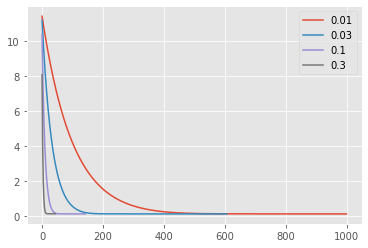

In [182]:
r_eval_hist_train, r_eval_hist_test = {}, {}
for eta, d in eval_hist.items():
    r_eval_hist_train[eta] = pd.Series(d['train-rmse-mean'])
    r_eval_hist_test[eta] = pd.Series(d['test-rmse-mean'])

r_eval_hist_train = pd.DataFrame(r_eval_hist_train)
r_eval_hist_test = pd.DataFrame(r_eval_hist_test)
r_eval_hist_test.plot(style='-')

In [183]:
pd.concat([r_eval_hist_test.idxmin().rename('num_boost'),
           r_eval_hist_test.min().rename('min_test_score'),
           r_eval_hist_train.where(r_eval_hist_test.apply(lambda x: x==x.min())).agg('sum').rename('min_train_score')], axis=1)

num_boost  min_test_score  min_train_score
0.01        968        0.128046         0.042278
0.03        606        0.127517         0.019840
0.10        142        0.129012         0.027391
0.30         44        0.134625         0.027271

In [184]:
dtrain = xgb.DMatrix(X_proc_xgb, label=y_proc, enable_categorical=True)

eval_hist_booster = {}
for booster in ["gbtree", "gblinear", "dart"]:
    eval_hist_booster[booster] = xgb.cv(
        params={"objective":"reg:squarederror", "eta":0.03, "eval_metric":"rmse", "booster":booster},
        dtrain=dtrain,
        num_boost_round=2_000,
        early_stopping_rounds=100,
        folds=fixed_folds,
        stratified=False,
        shuffle=False,
        metrics='rmse',
        verbose_eval=False,
    )

In [185]:
r_eval_hist_train, r_eval_hist_test = {}, {}
for booster, d in eval_hist_booster.items():
    r_eval_hist_train[booster] = pd.Series(d['train-rmse-mean'])
    r_eval_hist_test[booster] = pd.Series(d['test-rmse-mean'])

r_eval_hist_train = pd.DataFrame(r_eval_hist_train)
r_eval_hist_test = pd.DataFrame(r_eval_hist_test)

pd.concat([r_eval_hist_test.idxmin().rename('num_boost'),
           r_eval_hist_test.min().rename('min_test_score'),
           r_eval_hist_train.where(r_eval_hist_test.apply(lambda x: x==x.min())).agg('sum').rename('min_train_score')], axis=1)

num_boost  min_test_score  min_train_score
gbtree          606        0.127517          0.01984
gblinear       1999        0.218677          0.19617
dart            606        0.127517          0.01984

In [186]:
def objective(trial):
    dtrain = xgb.DMatrix(X_proc_xgb, label=y_proc)#, enable_categorical=True)
    
    params = dict(
        verbosity=0,
        objective="reg:squarederror",
        eval_metric="rmse",
        eta=0.03,
        max_depth=trial.suggest_int("max_depth", 2, 10),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-rmse")
    history = xgb.cv(
        params,
        dtrain,
        num_boost_round=2_000,
        early_stopping_rounds=100,
        folds=fixed_folds,
        stratified=False,
        shuffle=False,
        callbacks=[pruning_callback]
    )
    
    trial.set_user_attr("n_estimators", len(history))
    
    best_score = history["test-rmse-mean"].values[-1]
    return best_score

pruner = optuna.pruners.MedianPruner(n_warmup_steps=100)
xgb_study = optuna.create_study(pruner=pruner, direction="minimize")
xgb_study.optimize(objective, n_trials=200)

[I 2021-09-23 07:11:18,503] A new study created in memory with name: no-name-63493888-df2e-4798-875d-32cdc0df4f0e
[I 2021-09-23 07:11:23,043] Trial 0 finished with value: 0.12338640000000001 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'colsample_bytree': 0.5938600491426256, 'subsample': 0.26850389131183694, 'reg_alpha': 0.011417100776796621, 'reg_lambda': 0.2946787521884072}. Best is trial 0 with value: 0.12338640000000001.
[I 2021-09-23 07:11:32,889] Trial 1 finished with value: 0.1231262 and parameters: {'max_depth': 2, 'min_child_weight': 7, 'colsample_bytree': 0.3894214658473664, 'subsample': 0.9169698894962903, 'reg_alpha': 0.007656894569271849, 'reg_lambda': 1.1891296386677033}. Best is trial 1 with value: 0.1231262.
[I 2021-09-23 07:11:49,229] Trial 2 finished with value: 0.1369408 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'colsample_bytree': 0.7334116956447181, 'subsample': 0.7136477626416406, 'reg_alpha': 7.122446704903809, 'reg_lambda': 0.00065093454

In [187]:
# def objective(trial):
#     dtrain = xgb.DMatrix(X_proc, label=y_proc, enable_categorical=True)
    
#     param = {
#         "verbosity": 0,
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         "eta":0.1,
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#     }
    
#     if param["booster"] == "gbtree" or param["booster"] == "dart":
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
#     pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-rmse")
#     history = xgb.cv(
#         param,
#         dtrain,
#         num_boost_round=1_000,
#         early_stopping_rounds=100,
#         folds=fixed_folds,
#         stratified=False,
#         shuffle=False,
#         callbacks=[pruning_callback]
#     )
    
#     trial.set_user_attr("n_estimators", len(history))
    
#     best_score = history["test-rmse-mean"].values[-1]
#     return best_score

# pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
# xgb_study = optuna.create_study(pruner=pruner, direction="minimize")
# xgb_study.optimize(objective, n_trials=5)

In [188]:
print("Number of finished trials: {}".format(len(xgb_study.trials)))

print("Best trial:")
xgb_trial = xgb_study.best_trial

print("  Value: {}".format(xgb_trial.value))

print("  Params: ")
for key, value in xgb_trial.params.items():
    print("    {}: {}".format(key, value))
    
print("  Number of estimators: {}".format(xgb_trial.user_attrs["n_estimators"]))

Number of finished trials: 200
Best trial:
  Value: 0.12144060000000001
  Params: 
    max_depth: 5
    min_child_weight: 5
    colsample_bytree: 0.3100363456171262
    subsample: 0.21384554487370266
    reg_alpha: 0.00031333069997446837
    reg_lambda: 0.0014898167749872943
  Number of estimators: 495


In [189]:
display(optuna.visualization.plot_optimization_history(xgb_study))
display(optuna.visualization.plot_param_importances(xgb_study))

## LightGBM Hyperparameter Opt.

### Hyperparameter Opt. part 1

In [190]:
dtrain = lgb.Dataset(X_proc, y_proc, categorical_feature=columns_proc_category.tolist(), free_raw_data=False)

eval_hist = {}
for learning_rate in np.geomspace(1e-3, 1e-1, 5):
    eval_hist[learning_rate] = lgb.cv(
        params={"objective":"rmse", "learning_rate":learning_rate},
        train_set=dtrain,
        num_boost_round=10_000,
        early_stopping_rounds=100,
        folds=get_folds(),
        stratified=False,
        shuffle=False,
        metrics='rmse',
        verbose_eval=False,
    )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_c

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_c

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_c

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_c

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3962
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_c

<AxesSubplot:>

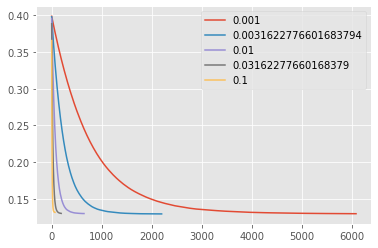

In [191]:
r_eval_hist = {}
for eta, d in eval_hist.items():
    r_eval_hist[eta] = pd.Series(d['rmse-mean'])
    
r_eval_hist = pd.DataFrame(r_eval_hist)
r_eval_hist.plot()

In [192]:
pd.concat([r_eval_hist.idxmin().rename('num_boost'),
           r_eval_hist.min().rename('min_test_score')], axis=1)

num_boost  min_test_score
0.001000       6081        0.129801
0.003162       2197        0.129516
0.010000        646        0.130031
0.031623        190        0.130232
0.100000         67        0.131699

### Hyperparameter Opt. part 2 with Optuna

In [193]:
import optuna
from optuna.integration import lightgbm as lgb_opt

dtrain = lgb_opt.Dataset(X_proc, y_proc) #, categorical_feature=columns_proc_category.tolist(), free_raw_data=False)

params = {
    "objective": "regression",
    "random_state": random_state,
    "metric": "rmse",
    "verbosity": -1,
    "learning_rate": 0.01,
    "num_threads":4,
}

study = optuna.create_study()
lgb_tuner = lgb_opt.LightGBMTunerCV(
    params=params,
    train_set=dtrain,
    folds=fixed_folds,
    #shuffle=False,
    #nfold=5,
    shuffle=False,
    stratified=False,
    #feature_name='auto',
    #categorical_feature=columns_proc_category,
    return_cvbooster=True,
    verbose_eval=-1,
    show_progress_bar=False,
    optuna_seed=random_state,
    early_stopping_rounds=100,
    num_boost_round=2_000,
    study=study,
)
lgb_tuner.run()

[I 2021-09-23 07:21:59,480] A new study created in memory with name: no-name-65160c61-dd7b-4606-ba72-29d0e178e52b
[I 2021-09-23 07:22:07,455] Trial 0 finished with value: 0.1262687738319226 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.1262687738319226.
[I 2021-09-23 07:22:15,154] Trial 1 finished with value: 0.12873693443374404 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.1262687738319226.
[I 2021-09-23 07:22:21,557] Trial 2 finished with value: 0.1250246555218903 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.1250246555218903.
[I 2021-09-23 07:22:29,642] Trial 3 finished with value: 0.1300733838880972 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.1250246555218903.
[I 2021-09-23 07:22:37,019] Trial 4 finished with value: 0.12739230877956703 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.1250246555218903.
[I 2021-09-23 07:22:46,202] Trial 5 finished with

In [194]:
optuna.visualization.plot_optimization_history(study)

In [195]:
lgb_tuner.get_best_booster().best_iteration

1102

In [196]:
print("Best score:", lgb_tuner.best_score)
best_params = lgb_tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12290619931796114
Best params: {'objective': 'regression', 'random_state': 42, 'metric': 'rmse', 'verbosity': -1, 'learning_rate': 0.01, 'num_threads': 4, 'feature_pre_filter': False, 'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413, 'num_leaves': 11, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2, 'min_child_samples': 20}
  Params: 
    objective: regression
    random_state: 42
    metric: rmse
    verbosity: -1
    learning_rate: 0.01
    num_threads: 4
    feature_pre_filter: False
    lambda_l1: 0.038720902953704193
    lambda_l2: 0.0024430162614261413
    num_leaves: 11
    feature_fraction: 0.41600000000000004
    bagging_fraction: 0.8994655844810855
    bagging_freq: 2
    min_child_samples: 20


# Stacking

Cannot use `sklearn.ensemble.StackingRegressor`, because:
1. to hyperoptimzie the final_estimator
2. because some of them need different processing (could use pipelines but would be a hassle)

In [197]:
# from sklearn.ensemble import StackingRegressor

I predict y from each model by hold-out like [sklearn.ensemble.StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) for proper Stacking (and avoid overfitting)

In [198]:
xgb_params = dict(verbosity=0,
                  objective="reg:squarederror",
                  eval_metric="rmse",
                  eta=0.03,
                  num_boost_round=2000, #num_boost_round=int(xgb_trial.user_attrs["n_estimators"]*2),
                  **xgb_trial.params)
print("XGB", xgb_params)

lgb_params = lgb_tuner.best_params
lgb_params['n_jobs'] = 1
lgb_params['n_estimators'] = int(lgb_tuner.get_best_booster().best_iteration*2) # 2000
lgb_params.pop('num_threads')
print("LGB", lgb_params)

XGB {'verbosity': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.03, 'num_boost_round': 2000, 'max_depth': 5, 'min_child_weight': 5, 'colsample_bytree': 0.3100363456171262, 'subsample': 0.21384554487370266, 'reg_alpha': 0.00031333069997446837, 'reg_lambda': 0.0014898167749872943}
LGB {'objective': 'regression', 'random_state': 42, 'metric': 'rmse', 'verbosity': -1, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.038720902953704193, 'lambda_l2': 0.0024430162614261413, 'num_leaves': 11, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.8994655844810855, 'bagging_freq': 2, 'min_child_samples': 20, 'n_jobs': 1, 'n_estimators': 2204}


In [199]:
svr_rbf = SVR(kernel='rbf', **study_rbf.best_params).fit(X_proc_norm, y_proc)
svr_poly = SVR(kernel='poly', **study_poly.best_params).fit(X_proc_norm, y_proc)
#elastic_net = model_linear.fit(X_proc_norm, y_proc)
ridge = ridge.fit(X_proc, y_proc)
lgbm = lgb.LGBMRegressor(**lgb_params).fit(X_proc, y_proc)
# xgbm = xgb.train({**xgb_params, **xgb_trial.params}, dtrain,
#                  num_boost_round=int(xgb_trial.user_attrs["n_estimators"]*1.2))
xgbm = xgb.XGBRegressor(**xgb_params).fit(X_proc_xgb, y_proc)

model_dict = {
    "xgbm": xgbm,
    "lgbm": lgbm,
    "svr_rbf": svr_rbf,
    "svr_poly": svr_poly,
    #"elastic_net": elastic_net,
    "ridge": ridge,
}

In [200]:
from sklearn.model_selection import cross_val_predict

X_out_all = X_proc.copy()
X_out_test_all = X_proc_test.copy()
X_out, X_out_test = pd.DataFrame(), pd.DataFrame()

final_score = {}

for name, model in model_dict.items():
    if name in ["svr_rbf", "svr_poly"]:
        X_train_estimator = X_proc_norm
        X_test_estimator = X_proc_norm_test
    elif name in ['xgbm']:
        X_train_estimator = X_proc_xgb
        X_test_estimator = X_proc_test_xgb
    else:
        X_train_estimator = X_proc
        X_test_estimator = X_proc_test
        
    #model.fit(X_train_estimator, y_proc)
    #s_train = model.predict(X_train_estimator)
    s_train = cross_val_predict(model, X_train_estimator, y_proc,
                                n_jobs=4, cv=5) # get_folds()
    s_test = model.predict(X_test_estimator)
    
    final_score[name] = mean_squared_error(y_proc, s_train, squared=False)
    print(name, final_score[name])
    
    X_out[f'out_{name}'] = pd.Series(s_train, X_proc.index)
    X_out_test[f'out_{name}'] = pd.Series(s_test, X_proc_test.index)
    
X_out_all = X_out_all.join(X_out)
X_out_test_all = X_out_test_all.join(X_out_test)

# pd.Series(final_score).to_frame().style.bar()

xgbm 0.5627795918267892
lgbm 0.11976600627794486
svr_rbf 0.12640986721218572
svr_poly 0.12657821777720665
ridge 0.13527151795573347


Matrix without initial columns (only outputs)

In [201]:
r_same_folds = cross_val_score(ExtraTreesRegressor(), X_out, y_proc,
                               cv=get_folds(),
                               scoring='neg_root_mean_squared_error')

r_new_folds_5 = cross_val_score(ExtraTreesRegressor(), X_out, y_proc,
                              cv=5,
                              scoring='neg_root_mean_squared_error')

r_new_folds_10 = cross_val_score(ExtraTreesRegressor(), X_out, y_proc,
                              cv=10,
                              scoring='neg_root_mean_squared_error')

print("same folds:", -r_same_folds.mean(), "random 5 new folds:", -r_new_folds_5.mean(), "random 10 new folds:", -r_new_folds_10.mean())

same folds: 0.12425245942936428 random 5 new folds: 0.11723949469028498 random 10 new folds: 0.11691211838962426


In [202]:
# r_same_folds = cross_val_score(LinearRegression(), X_out, y_proc,
#                                cv=get_folds(),
#                                scoring='neg_root_mean_squared_error')

# r_new_folds = cross_val_score(LinearRegression(), X_out, y_proc,
#                               cv=5,
#                               scoring='neg_root_mean_squared_error')

# print("same folds:", -r_same_folds.mean(), "random 5 new folds:", -r_new_folds.mean())
# #>>>same folds: 0.11607714315880906 random new folds: 0.1275152949072265

Matrix with initial columns

In [203]:
r_same_folds = cross_val_score(ExtraTreesRegressor(), X_out_all, y_proc,
                               cv=get_folds(),
                               scoring='neg_root_mean_squared_error')

r_new_folds_5 = cross_val_score(ExtraTreesRegressor(), X_out_all, y_proc,
                              cv=5,
                              scoring='neg_root_mean_squared_error')

r_new_folds_10 = cross_val_score(ExtraTreesRegressor(), X_out_all, y_proc,
                              cv=10,
                              scoring='neg_root_mean_squared_error')

print("same folds:", -r_same_folds.mean(), "random 5 new folds:", -r_new_folds_5.mean(), "random 10 new folds:", -r_new_folds_10.mean())

same folds: 0.12217860347410112 random 5 new folds: 0.11721951232659507 random 10 new folds: 0.11519096246133467


In [204]:
r_same_folds = cross_val_score(RidgeCV(), X_out_all, y_proc,
                               cv=get_folds(),
                               scoring='neg_root_mean_squared_error')

r_new_folds_5 = cross_val_score(RidgeCV(), X_out_all, y_proc,
                              cv=5,
                              scoring='neg_root_mean_squared_error')

r_new_folds_10 = cross_val_score(RidgeCV(), X_out_all, y_proc,
                              cv=10,
                              scoring='neg_root_mean_squared_error')

print("same folds:", -r_same_folds.mean(), "random 5 new folds:", -r_new_folds_5.mean(), "random 10 new folds:", -r_new_folds_10.mean())
#>>>same folds: 0.11607714315880906 random new folds: 0.1275152949072265

same folds: 0.11454561844169997 random 5 new folds: 0.11073489598971002 random 10 new folds: 0.10862084950049702


In [205]:
def objective(trial):
    
    max_depth_isnone = trial.suggest_categorical("max_depth_isnone", [True, False])
    if not max_depth_isnone:
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    else:
        max_depth = None
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 64, log=True)
    max_features = trial.suggest_categorical("max_features", ['auto','sqrt','log2'])
    n_estimators = trial.suggest_categorical("n_estimators", [100, 1000]) 
    
    model = ExtraTreesRegressor(criterion='mse',
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                max_features=max_features,
                                random_state=random_state)
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state+1)
    r = cross_val_score(model, X_out_all, y_proc,
                        cv=folds.split(X_proc, y_encoded),
                        scoring='neg_root_mean_squared_error')
    return -r.mean()

study_final = optuna.create_study()
study_final.optimize(objective, n_trials=40)

[I 2021-09-23 07:32:14,995] A new study created in memory with name: no-name-d631b9e8-10e9-424d-a5ec-2b5fdfdecd14
[I 2021-09-23 07:32:20,429] Trial 0 finished with value: 0.20287688867573844 and parameters: {'max_depth_isnone': False, 'max_depth': 3, 'min_samples_leaf': 68, 'min_samples_split': 43, 'max_features': 'sqrt', 'n_estimators': 1000}. Best is trial 0 with value: 0.20287688867573844.
[I 2021-09-23 07:32:27,005] Trial 1 finished with value: 0.15170012966086194 and parameters: {'max_depth_isnone': False, 'max_depth': 10, 'min_samples_leaf': 28, 'min_samples_split': 8, 'max_features': 'sqrt', 'n_estimators': 1000}. Best is trial 1 with value: 0.15170012966086194.
[I 2021-09-23 07:32:33,153] Trial 2 finished with value: 0.1595117659336337 and parameters: {'max_depth_isnone': True, 'min_samples_leaf': 21, 'min_samples_split': 25, 'max_features': 'log2', 'n_estimators': 1000}. Best is trial 1 with value: 0.15170012966086194.
[I 2021-09-23 07:32:42,784] Trial 3 finished with value: 0

In [206]:
print("Best score:", study_final.best_value)
print(study_final.best_params)

print("Best params:", study_final.best_params)
print("  Params: ")
for key, value in study_final.best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.11292853613973981
{'max_depth_isnone': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7, 'max_features': 'auto', 'n_estimators': 1000}
Best params: {'max_depth_isnone': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 7, 'max_features': 'auto', 'n_estimators': 1000}
  Params: 
    max_depth_isnone: False
    max_depth: 5
    min_samples_leaf: 1
    min_samples_split: 7
    max_features: auto
    n_estimators: 1000


In [207]:
display(optuna.visualization.plot_optimization_history(study_final))
display(optuna.visualization.plot_param_importances(study_final))

In [208]:
final_best_params = dict(study_final.best_params)
final_best_params.pop('max_depth_isnone')
if study_final.best_params['max_depth_isnone']:
    final_best_params['max_depth'] = None

final_estimator = ExtraTreesRegressor(criterion='mse', **final_best_params).fit(X_out_all, y_proc)

## Summary

Our final leaderboard score should be close to the value below:

In [209]:
r = cross_val_score(final_estimator, X_out_all, y_proc,
                    cv=get_folds(), scoring='neg_root_mean_squared_error')

print("final score in old-out/CV:", -r.mean())

final score in old-out/CV: 0.11986420262976949


In [210]:
final_estimator.fit(X_out_all, y_proc)
y_pred = final_estimator.predict(X_out_all)
y_pred = pd.Series(y_pred, index=y_proc.index, name='predictions')
y_pred_test = final_estimator.predict(X_out_test_all)

print("final 'training' score on training data:", mean_squared_error(y_proc, y_pred, squared=False))

final 'training' score on training data: 0.09619612882753815


With LinearRegression as final estimator

In [211]:
# r = cross_val_score(LinearRegression(), X_out_all, y_proc,
#                     cv=get_folds(), scoring='neg_root_mean_squared_error')

# print("final score in old-out/CV:", -r.mean())

In [212]:
# final_lr = LinearRegression().fit(X_out_all, y_proc)
# y_pred_lr = final_lr.predict(X_out_all)
# y_pred_lr = pd.Series(y_pred_lr, index=y_proc.index, name='predictions')
# y_pred_test_lr = final_lr.predict(X_out_test_all)

# print("final 'training' score on training data:", mean_squared_error(y_proc, y_pred, squared=False))

# Output visualization

<AxesSubplot:xlabel='SalePrice', ylabel='predictions'>

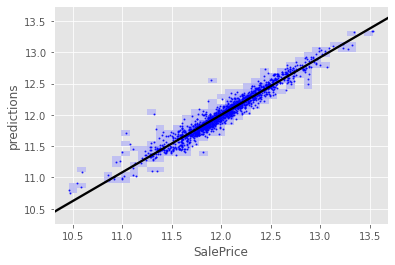

In [213]:
fig, ax = plt.subplots()
sns.histplot(x=y_proc, y=y_pred, color='b')
sns.regplot(x=y_proc, y=y_pred, color='b', truncate=False, line_kws={"color":"k"}, scatter_kws={"s": 1}, ax=ax)

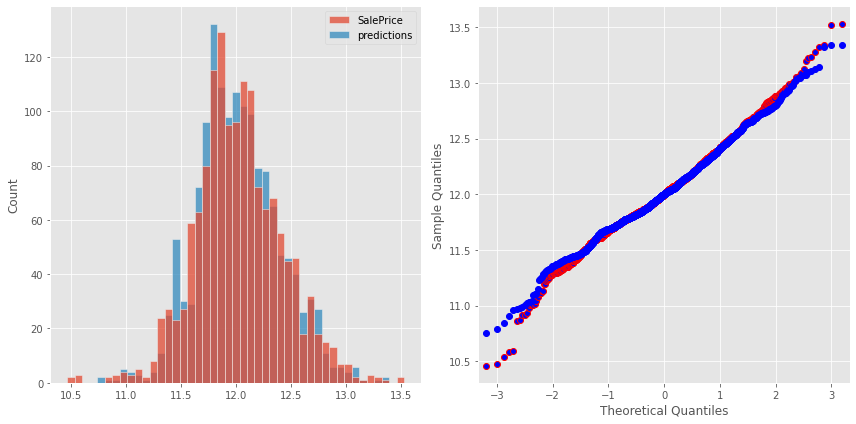

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot([y_proc, y_pred], ax=axs[0], color=['r', 'b'])
sm.ProbPlot(y_proc.values).qqplot(ax=axs[1], fmt='r')
sm.ProbPlot(y_pred).qqplot(ax=axs[1], fmt='b')
plt.tight_layout()

With Linear Regression

In [215]:
# fig, ax = plt.subplots()
# sns.histplot(x=y_proc, y=y_pred_lr, color='b')
# sns.regplot(x=y_proc, y=y_pred_lr, color='b', truncate=False, line_kws={"color":"k"}, scatter_kws={"s": 1}, ax=ax)

In [216]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# sns.histplot([y_proc, y_pred_lr], ax=axs[0], color=['r', 'b'])
# sm.ProbPlot(y_proc.values).qqplot(ax=axs[1], fmt='r')
# sm.ProbPlot(y_pred_lr).qqplot(ax=axs[1], fmt='b')
# plt.tight_layout()

Manual refinment does not work

In [217]:
# def refinment(y):
#     y = y.copy()
#     index_q1 = y < (y.mean() - y.std())
#     #index_q3 = y > (y.mean() + 2*y.std())
#     y[index_q1] = y[index_q1] ** 0.999
#     #y[index_q3] = y[index_q3] ** 1
#     return y

# y_pred_refi = refinment(y_pred)

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# sns.histplot([y_proc, y_pred_refi], ax=axs[0], color=['r', 'g'])
# sm.ProbPlot(y_proc.values).qqplot(ax=axs[1], fmt='r')
# sm.ProbPlot(y_pred_refi).qqplot(ax=axs[1], fmt='b')
# plt.tight_layout()

# print("final score on training data:", mean_squared_error(y_proc, y_pred_refi, squared=False))
## >>> final score on training data: 0.09899767369324648

# Submission

In [218]:
def submit(y_pred, name):
    ys = pd.DataFrame(np.exp(y_pred), index=X_test.index, columns=[y.name])
    ys.to_csv(f"{name}.csv")
    return ys

try:
    os.mkdir('kaggle/output/house-prices-advanced-regression-techniques')
except:
    pass

In [219]:
for name, _ in model_dict.items():
    submit(X_out_test[f'out_{name}'].values, name)
    
X_out_test

out_xgbm   out_lgbm  out_svr_rbf  out_svr_poly  out_ridge
Id                                                              
1461  11.216722  11.753426    11.686595     11.671643  11.724407
1462  11.410118  11.996757    11.988644     11.989029  11.980097
1463  11.569840  12.123986    12.148739     12.136697  12.103289
1464  11.588675  12.181255    12.198277     12.197960  12.200769
1465  11.590405  12.149488    12.158542     12.174234  12.171970
...         ...        ...          ...           ...        ...
2915  10.830009  11.323710    11.390367     11.361789  11.424701
2916  10.841533  11.319691    11.351364     11.321612  11.357939
2917  11.407146  12.005242    12.066341     12.040867  11.916873
2918  11.119436  11.655500    11.716245     11.672473  11.731574
2919  11.681640  12.230339    12.323425     12.307537  12.315108

[1459 rows x 5 columns]

In [220]:
submit(y_pred_test, 'final')

SalePrice
Id                 
1461  121609.378855
1462  160186.798210
1463  182504.027504
1464  194099.037151
1465  188222.850908
...             ...
2915   89663.395021
2916   88285.514192
2917  164047.782651
2918  119278.598943
2919  215300.128500

[1459 rows x 1 columns]

In [221]:
# submit(y_pred_test_lr, 'final_lr')